In [313]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
import warnings
import os

In [314]:
# Getting the display settings so that we can see all of the data
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', None)  

# Load Dataset
---

In [315]:
# loading the csv into a dataframe using pandas
crime_df = pd.read_csv('../data/crimedata2.csv',encoding='latin-1')

## Data Cleaning and Preparation
---

In [316]:
crime_df = crime_df.replace('?', np.nan)

In [317]:
# convert all columns to appropriate data types
for col in crime_df.drop(["state", "Êcommunityname", "countyCode", "communityCode"], axis=1).columns:
    if crime_df[col].dtype == "object":
        crime_df[col] = pd.to_numeric(crime_df[col], errors='coerce')

In [318]:
crime_df = crime_df.dropna(axis=1, how="all")

In [319]:
crime_df.head()

,Êcommunityname,state,countyCode,communityCode,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,FemalePctDiv,TotalPctDiv,PersPerFam,PctFam2Par,PctKids2Par,PctYoungKids2Par,PctTeen2Par,PctWorkMomYoungKids,PctWorkMom,NumKidsBornNeverMar,PctKidsBornNeverMar,NumImmig,PctImmigRecent,PctImmigRec5,PctImmigRec8,PctImmigRec10,PctRecentImmig,PctRecImmig5,PctRecImmig8,PctRecImmig10,PctSpeakEnglOnly,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,OwnOccQrange,RentLowQ,RentMedian,RentHighQ,RentQrange,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,murders,murdPerPop,rapes,rapesPerPop,robberies,robbbPerPop,assaults,assaultPerPop,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
0,BerkeleyHeightstownship,NJ,39,5320,1,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,11.33,11980,100.0,75122,89.24,1.55,70.20,23.62,1.03,18.39,79584,29711,30233,13600,5725,27101,5115.0,22838,227,1.96,5.81,9.90,48.18,2.70,64.55,14.65,28.82,5.49,50.73,3.67,26.38,5.22,4.47,3.22,91.43,90.17,95.78,95.81,44.56,58.88,31,0.36,1277,8.69,13.00,20.99,30.93,0.93,1.39,2.24,3.30,85.68,1.37,4.81,4.17,2.99,3.00,2.84,91.46,0.39,11.06,3,64,98.37,91.01,3.12,37.50,1959,0.00,0.28,215900,262600,326900,111000,685,1001,1001,316,1001,23.8,21.1,14.0,11,0,10.66,53.72,65.29,78.09,89.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5,1845.9,9.63,NaN,NaN,NaN,NaN,0.0,NaN,0,0.0,0.0,0.00,1.0,8.20,4.0,32.81,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59
1,Marpletownship,PA,45,47616,1,23123,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,17.18,23123,100.0,47917,78.99,1.11,64.11,35.50,2.75,22.85,55323,20148,20191,18137,0,20074,5250.0,12222,885,3.98,5.61,13.72,29.89,2.43,61.96,12.26,29.28,6.39,37.64,4.23,27.99,6.45,5.42,3.11,86.91,85.33,96.82,86.46,51.14,62.43,43,0.24,1920,5.21,8.65,13.33,22.50,0.43,0.72,1.11,1.87,87.79,1.81,4.25,3.34,2.70,2.83,1.96,89.03,1.01,23.60,3,240,97.15,84.88,0.00,18.33,1958,0.31,0.14,136300,164200,199900,63600,467,560,672,205,627,27.6,20.7,12.5,0,0,8.30,77.17,71.27,90.22,96.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.6,2186.7,3.84,NaN,NaN,NaN,NaN,0.0,NaN,0,0.0,1.0,4.25,5.0,21.26,24.0,102.05,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95
2,Tigardcity,OR,NaN,NaN,1,29344,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,10.28,29344,100.0,35669,82.00,1.15,55.73,22.25,2.94,14.56,42112,16946,17103,16644,21606,15528,5954.0,8405,1389,4.75,2.80,9.09,30.13,4.01,69.80,15.95,21.52,8.79,32.48,10.10,25.78,14.76,12.55,2.95,78.54,78.85,92.37,75.72,66.08,74.19,164,0.88,1468,16.42,23.98,32.08,35.63,0.82,1.20,1.61,1.78,93.11,1.14,2.97,2.05,2.42,2.69,2.06,64.18,2.03,47.46,3,544,95.68,57.79,0.92,7.54,1976,1.55,0.12,74700,90400,1120

In [320]:
# Calculate the number of missing values per column
missing_counts = crime_df.isnull().sum()

# Calculate the percentage of missing values per column
missing_percentage = (missing_counts / len(crime_df)) * 100

# Combine the counts and percentages into a single DataFrame
missing_values_df = pd.DataFrame({
    'Missing_Count': missing_counts,
    'Missing_Percentage': missing_percentage
})

# Sort the DataFrame by percentage of missing values in descending order
missing_values_df = missing_values_df.sort_values(by='Missing_Percentage', ascending=False)

# Display the missing values DataFrame
print(missing_values_df)

                       Missing_Count  Missing_Percentage
PctPolicBlack                   1872           84.514673
PolicReqPerOffic                1872           84.514673
PolicPerPop                     1872           84.514673
PolicCars                       1872           84.514673
PolicOperBudg                   1872           84.514673
LemasPctPolicOnPatr             1872           84.514673
PolicAveOTWorked                1872           84.514673
LemasGangUnitDeploy             1872           84.514673
PolicBudgPerPop                 1872           84.514673
PctPolicWhite                   1872           84.514673
RacialMatchCommPol              1872           84.514673
LemasSwornFT                    1872           84.514673
LemasSwFTPerPop                 1872           84.514673
LemasSwFTFieldOps               1872           84.514673
LemasSwFTFieldPerPop            1872           84.514673
NumKindsDrugsSeiz               1872           84.514673
OfficAssgnDrugUnits            

In [321]:
population_features  = ["population"]
crime_features       = [ "autoTheft", "autoTheftPerPop", "larcenies", "larcPerPop", "burglaries", "burglPerPop", "robberies", "robbbPerPop"]
money_features       = ["medIncome", "RentMedian", "MedRent"]
race_features        = ["racepctblack", "racePctWhite", "racePctAsian", "racePctHisp"]
age_features         = ["agePct12t21", "agePct12t29", "agePct16t24", "agePct65up"]
categorical_features = ['Êcommunityname', 'state', 'countyCode', 'communityCode']
drop_list = [
    'LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop', 
    'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerOffic', 'PolicPerPop', 
    'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 
    'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz', 
    'PolicAveOTWorked', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr', 
    'LemasGangUnitDeploy', 'PolicBudgPerPop'
]


In [322]:
crime_df = crime_df.drop(drop_list, axis=1)

In [323]:
numerical_cols = crime_df.drop("fold", axis=1).select_dtypes(include=['float64', 'int64']).columns
crime_df[numerical_cols] = crime_df[numerical_cols].fillna(crime_df[numerical_cols].median())

In [324]:
crime_df.head()

,Êcommunityname,state,countyCode,communityCode,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,FemalePctDiv,TotalPctDiv,PersPerFam,PctFam2Par,PctKids2Par,PctYoungKids2Par,PctTeen2Par,PctWorkMomYoungKids,PctWorkMom,NumKidsBornNeverMar,PctKidsBornNeverMar,NumImmig,PctImmigRecent,PctImmigRec5,PctImmigRec8,PctImmigRec10,PctRecentImmig,PctRecImmig5,PctRecImmig8,PctRecImmig10,PctSpeakEnglOnly,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,OwnOccQrange,RentLowQ,RentMedian,RentHighQ,RentQrange,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,murders,murdPerPop,rapes,rapesPerPop,robberies,robbbPerPop,assaults,assaultPerPop,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
0,BerkeleyHeightstownship,NJ,39,5320,1,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,11.33,11980,100.0,75122,89.24,1.55,70.20,23.62,1.03,18.39,79584,29711,30233,13600,5725,27101,5115.0,22838,227,1.96,5.81,9.90,48.18,2.70,64.55,14.65,28.82,5.49,50.73,3.67,26.38,5.22,4.47,3.22,91.43,90.17,95.78,95.81,44.56,58.88,31,0.36,1277,8.69,13.00,20.99,30.93,0.93,1.39,2.24,3.30,85.68,1.37,4.81,4.17,2.99,3.00,2.84,91.46,0.39,11.06,3,64,98.37,91.01,3.12,37.50,1959,0.00,0.28,215900,262600,326900,111000,685,1001,1001,316,1001,23.8,21.1,14.0,11,0,10.66,53.72,65.29,78.09,89.14,6.5,1845.9,9.63,0.0,0,0.0,0.0,0.00,1.0,8.20,4.0,32.81,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59
1,Marpletownship,PA,45,47616,1,23123,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,17.18,23123,100.0,47917,78.99,1.11,64.11,35.50,2.75,22.85,55323,20148,20191,18137,0,20074,5250.0,12222,885,3.98,5.61,13.72,29.89,2.43,61.96,12.26,29.28,6.39,37.64,4.23,27.99,6.45,5.42,3.11,86.91,85.33,96.82,86.46,51.14,62.43,43,0.24,1920,5.21,8.65,13.33,22.50,0.43,0.72,1.11,1.87,87.79,1.81,4.25,3.34,2.70,2.83,1.96,89.03,1.01,23.60,3,240,97.15,84.88,0.00,18.33,1958,0.31,0.14,136300,164200,199900,63600,467,560,672,205,627,27.6,20.7,12.5,0,0,8.30,77.17,71.27,90.22,96.12,10.6,2186.7,3.84,0.0,0,0.0,1.0,4.25,5.0,21.26,24.0,102.05,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95
2,Tigardcity,OR,NaN,NaN,1,29344,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,10.28,29344,100.0,35669,82.00,1.15,55.73,22.25,2.94,14.56,42112,16946,17103,16644,21606,15528,5954.0,8405,1389,4.75,2.80,9.09,30.13,4.01,69.80,15.95,21.52,8.79,32.48,10.10,25.78,14.76,12.55,2.95,78.54,78.85,92.37,75.72,66.08,74.19,164,0.88,1468,16.42,23.98,32.08,35.63,0.82,1.20,1.61,1.78,93.11,1.14,2.97,2.05,2.42,2.69,2.06,64.18,2.03,47.46,3,544,95.68,57.79,0.92,7.54,1976,1.55,0.12,74700,90400,112000,37300,370,428,520,150,484,24.1,21.7,11.6,16,0,5.00,44.77,36.60,61.26,82.85,10.6,2780.9,4.37,0.0,3,8.3,6.0,16.60,56.0,154.95,14.0,38.74,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,218.59,6167.51
3,Gloversvillecity,NY,35,29443,1,16656,2.40,1.70,97.35,0.50,0.70,12.55,25.20,12.19,17.57,0,0.0,20580,68.15,0.24,38.95,39.48,11.71,18.33,26501,10810,10909,9984,4941,3541,2451.0,4391,2831,17.23,11.05,33.68,10.81,9.86,54.74,31.22,27.43,26.76,22.71,10.98,28.15,14.47,12.91,2.98,64.02,62.36,65.38,67.43,59.59,70.27,561,3.84,339,

In [325]:

def multiple_barplots(dataframe:pd.DataFrame, x:str|list, y:str|list[str],  title:str=None, n_rows:int=1, n_cols:int=1, figsize:tuple=(9, 4), xtick_rotation:int=0, sharex:bool=True, sharey:bool=True, errorbar:tuple|bool=None)->None:
    fig, ax = plt.subplots(n_rows, n_cols, sharex=sharex, sharey=sharey, figsize=figsize)
    col_index = 0

    if n_rows>1 and n_cols>1:
        for i in range(n_rows):
            for j in range(n_cols):
                ax[i][j] = sns.barplot(data=dataframe, x=x, y=y[col_index], ax=ax[i][j], errorbar=errorbar)
                ax[i][j].tick_params(rotation=xtick_rotation)
                ax[i][j].set_title(f"{y[col_index]} vs {x}")
                ax[i][j].set(ylabel=None, xlabel=None)
                col_index += 1
    elif n_cols > 1:
        for j in range(n_cols):
            ax[j] = sns.barplot(data=dataframe, x=x, y=y[col_index], ax=ax[j], errorbar=errorbar)
            ax[j].tick_params(rotation=xtick_rotation)
            ax[j].set_title(f"{y[col_index]} vs {x}")
            ax[j].set(ylabel=None, xlabel=None)
            col_index += 1
    fig.suptitle(title)
    plt.tight_layout()
    fig.show()
plt.rcParams.update({'font.size': 18})


In [326]:
# Add regions based on state
def assign_region(state):
    northeast = ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA']
    southeast = ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'DC', 'WV', 'AL', 'KY', 'MS', 'TN', 'AR', 'LA']
    midwest = ['IL', 'IN', 'MI', 'OH', 'WI', 'IA', 'KS', 'MO', 'NE', 'ND', 'SD', 'MN']
    southwest = ['AZ', 'NM', 'OK', 'TX']
    west = ['CO', 'ID', 'MT', 'NV', 'UT', 'WY', 'AK', 'CA', 'HI', 'OR', 'WA']
    
    if state in northeast:
        return 'Northeast'
    elif state in southeast:
        return 'Southeast'
    elif state in midwest:
        return 'Midwest'
    elif state in southwest:
        return 'Southwest'
    elif state in west:
        return 'West'
    else:
        return 'Unknown'

In [327]:
crime_df['region'] = crime_df['state'].apply(assign_region)

C:\Users\riain\AppData\Local\Temp\ipykernel_30688\2047208763.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  crime_df['region'] = crime_df['state'].apply(assign_region)


In [328]:
# Drop columns that are not useful for modeling
crime_df = crime_df.drop(columns=['state', 'Êcommunityname', 'countyCode', 'communityCode', "fold"])

In [329]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select minority percentage columns
minority_pct_cols = ['racepctblack', 'racePctAsian', 'racePctHisp', 'indianPerCap']

# Standardize the data
scaler = StandardScaler()
minority_scaled = scaler.fit_transform(crime_df[minority_pct_cols])

# Apply PCA to reduce to a single component
pca = PCA(n_components=1)
crime_df['Minority_Index'] = pca.fit_transform(minority_scaled)

# Optionally, bin the composite index
crime_df['Minority_Index_binned'] = pd.qcut(crime_df['Minority_Index'], q=3, labels=['Low', 'Medium', 'High'])

# One-hot encode the binned index
# crime_df = pd.get_dummies(
#     crime_df,
#     columns=['Minority_Index_binned'],
#     # drop_first=True  # To avoid multicollinearity
# )

# Verification
# crime_df= crime_df.drop(["Minority_Index_binned_Low", "Minority_Index_binned_Medium", "Minority_Index_binned_High"], axis=1)
crime_df.head()
# graph minority index based on region


C:\Users\riain\AppData\Local\Temp\ipykernel_30688\2623783339.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  crime_df['Minority_Index'] = pca.fit_transform(minority_scaled)
C:\Users\riain\AppData\Local\Temp\ipykernel_30688\2623783339.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  crime_df['Minority_Index_binned'] = pd.qcut(crime_df['Minority_Index'], q=3, labels=['Low', 'Medium', 'High'])


,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,FemalePctDiv,TotalPctDiv,PersPerFam,PctFam2Par,PctKids2Par,PctYoungKids2Par,PctTeen2Par,PctWorkMomYoungKids,PctWorkMom,NumKidsBornNeverMar,PctKidsBornNeverMar,NumImmig,PctImmigRecent,PctImmigRec5,PctImmigRec8,PctImmigRec10,PctRecentImmig,PctRecImmig5,PctRecImmig8,PctRecImmig10,PctSpeakEnglOnly,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,OwnOccQrange,RentLowQ,RentMedian,RentHighQ,RentQrange,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,murders,murdPerPop,rapes,rapesPerPop,robberies,robbbPerPop,assaults,assaultPerPop,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop,region,Minority_Index,Minority_Index_binned
0,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,11.33,11980,100.0,75122,89.24,1.55,70.20,23.62,1.03,18.39,79584,29711,30233,13600,5725,27101,5115.0,22838,227,1.96,5.81,9.90,48.18,2.70,64.55,14.65,28.82,5.49,50.73,3.67,26.38,5.22,4.47,3.22,91.43,90.17,95.78,95.81,44.56,58.88,31,0.36,1277,8.69,13.00,20.99,30.93,0.93,1.39,2.24,3.30,85.68,1.37,4.81,4.17,2.99,3.00,2.84,91.46,0.39,11.06,3,64,98.37,91.01,3.12,37.50,1959,0.00,0.28,215900,262600,326900,111000,685,1001,1001,316,1001,23.8,21.1,14.0,11,0,10.66,53.72,65.29,78.09,89.14,6.5,1845.9,9.63,0.0,0,0.0,0.0,0.00,1.0,8.20,4.0,32.81,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59,Northeast,0.453524,High
1,23123,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,17.18,23123,100.0,47917,78.99,1.11,64.11,35.50,2.75,22.85,55323,20148,20191,18137,0,20074,5250.0,12222,885,3.98,5.61,13.72,29.89,2.43,61.96,12.26,29.28,6.39,37.64,4.23,27.99,6.45,5.42,3.11,86.91,85.33,96.82,86.46,51.14,62.43,43,0.24,1920,5.21,8.65,13.33,22.50,0.43,0.72,1.11,1.87,87.79,1.81,4.25,3.34,2.70,2.83,1.96,89.03,1.01,23.60,3,240,97.15,84.88,0.00,18.33,1958,0.31,0.14,136300,164200,199900,63600,467,560,672,205,627,27.6,20.7,12.5,0,0,8.30,77.17,71.27,90.22,96.12,10.6,2186.7,3.84,0.0,0,0.0,1.0,4.25,5.0,21.26,24.0,102.05,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95,Northeast,-0.097546,Medium
2,29344,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,10.28,29344,100.0,35669,82.00,1.15,55.73,22.25,2.94,14.56,42112,16946,17103,16644,21606,15528,5954.0,8405,1389,4.75,2.80,9.09,30.13,4.01,69.80,15.95,21.52,8.79,32.48,10.10,25.78,14.76,12.55,2.95,78.54,78.85,92.37,75.72,66.08,74.19,164,0.88,1468,16.42,23.98,32.08,35.63,0.82,1.20,1.61,1.78,93.11,1.14,2.97,2.05,2.42,2.69,2.06,64.18,2.03,47.46,3,544,95.68,57.79,0.92,7.54,1976,1.55,0.12,74700,90400,112000,37300,370,428,520,150,484,24.1,21.7,11.6,16,0,5.00,44.77,36.60,61.26,82.85,10.6,2780.9,4.37,0.0,3,8.3,6.0,16.60,56.0,154.95,14.0,38.74,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,218.59,6167.51,West,0.248827,High
3,16656,2.40,1.70,97.35,0.50,0.70,12.55,25.20,12.19,17.57,0,0.0,20580,68.15,0.24,38.95,39.48,11.71,18.33,26501,10810,10909,9984,4941,3541,2451.0,4391,2831,17.23,11.05,33.68,10.81,9.86,54.74,31.22,27.43,26.76,22.71,10.98,28.15,14.47,12.91,2.98,64.02,62.36,65.38,67.43,59.59,70.27,561,3.84,339,13.86,13.86,15.34,15.34,0.28,0.28,0.31,0.31,94.98,0.56,3.9

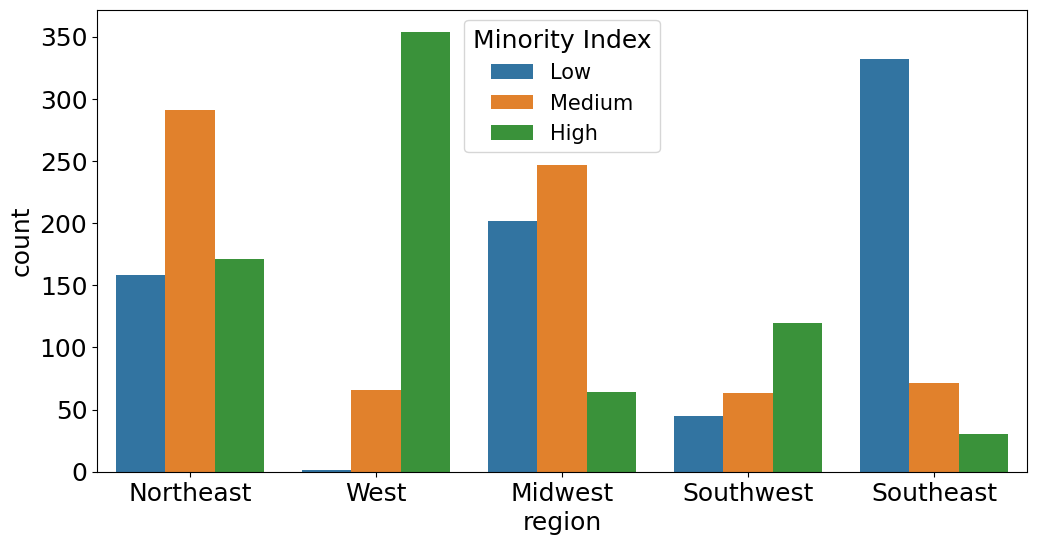

In [330]:
# Graph the minority index binned value counts based on region with bigger graph size and small legend size
plt.figure(figsize=(12, 6))
sns.countplot(data=crime_df, x='region', hue='Minority_Index_binned')
# plt.title('Minority Index Binned by Region')
plt.legend(title='Minority Index', fontsize='small')
plt.show()

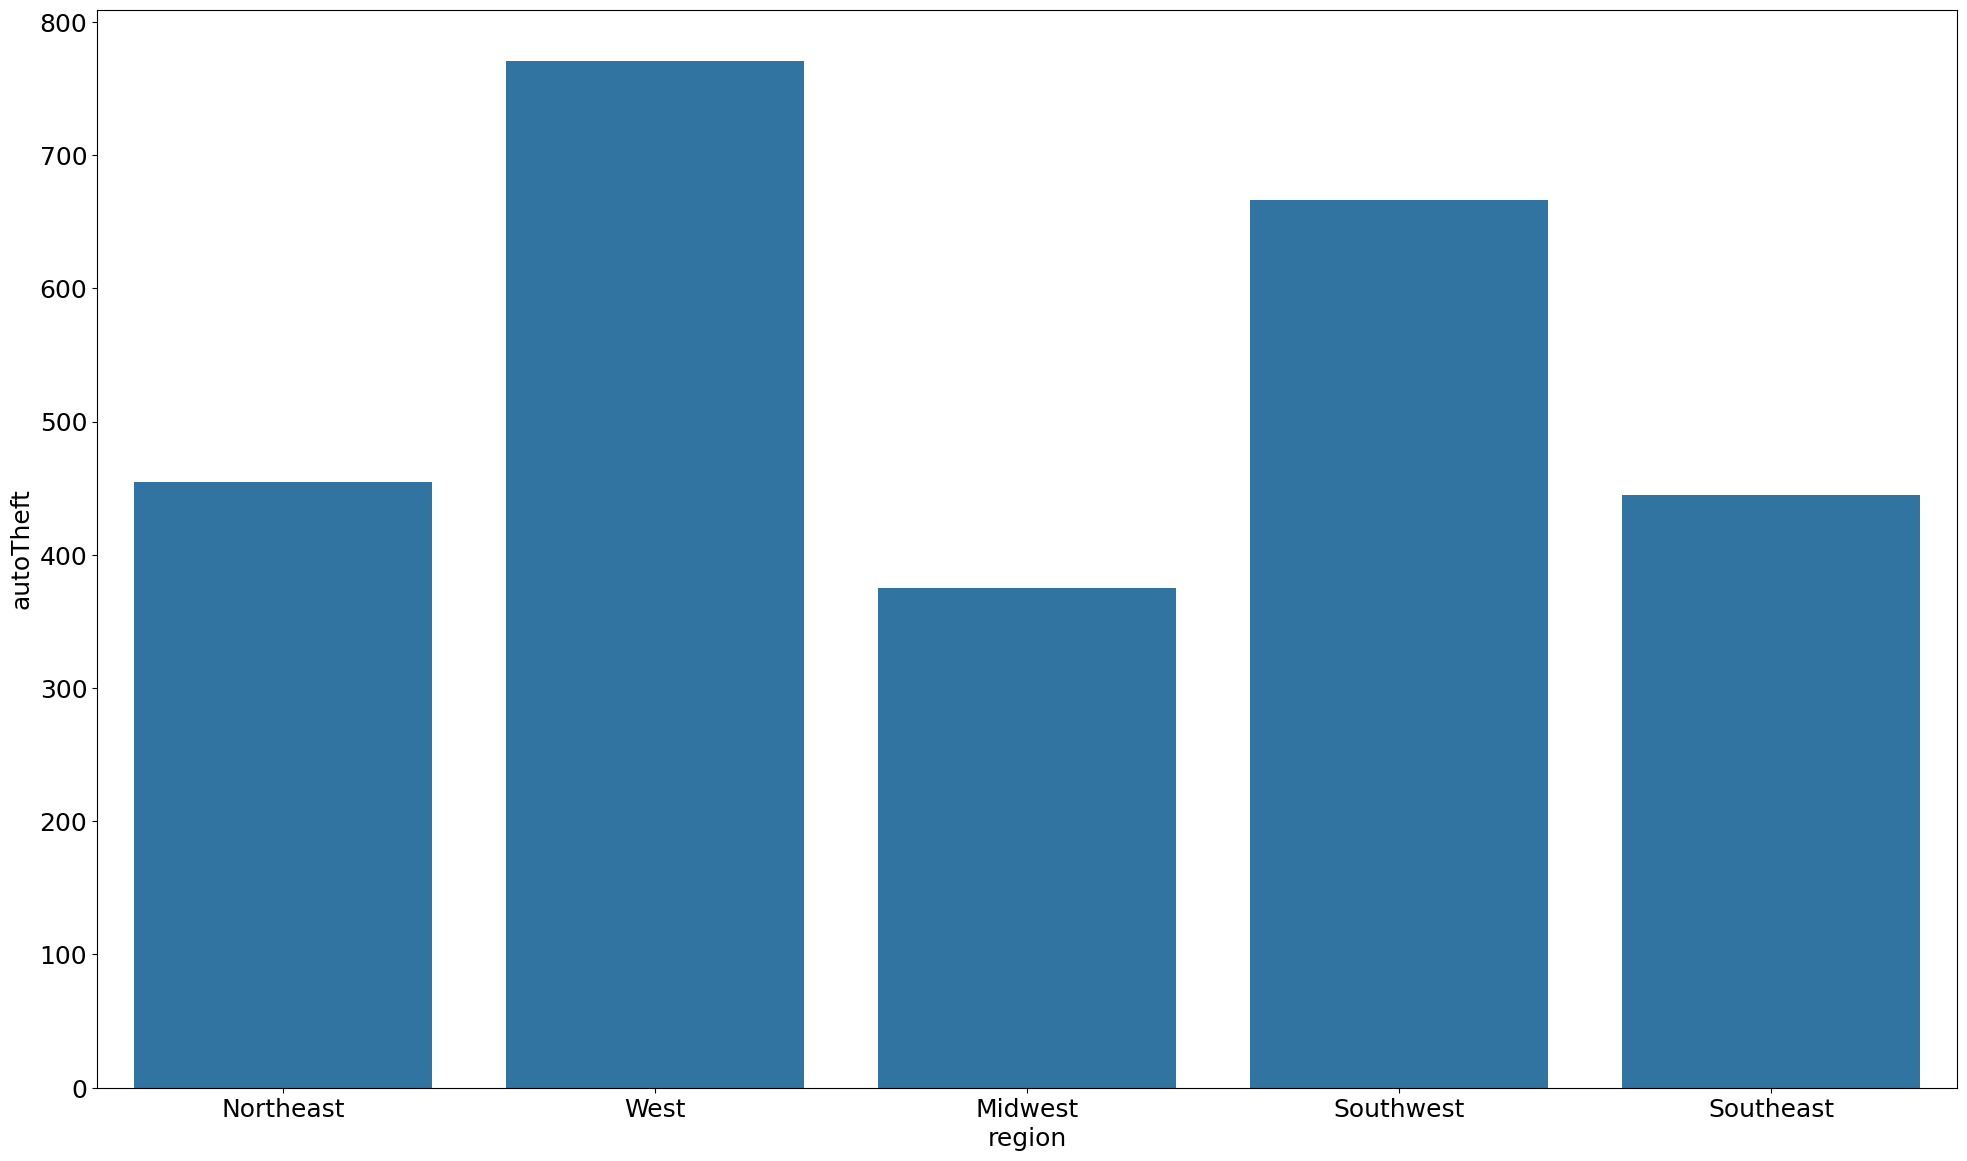

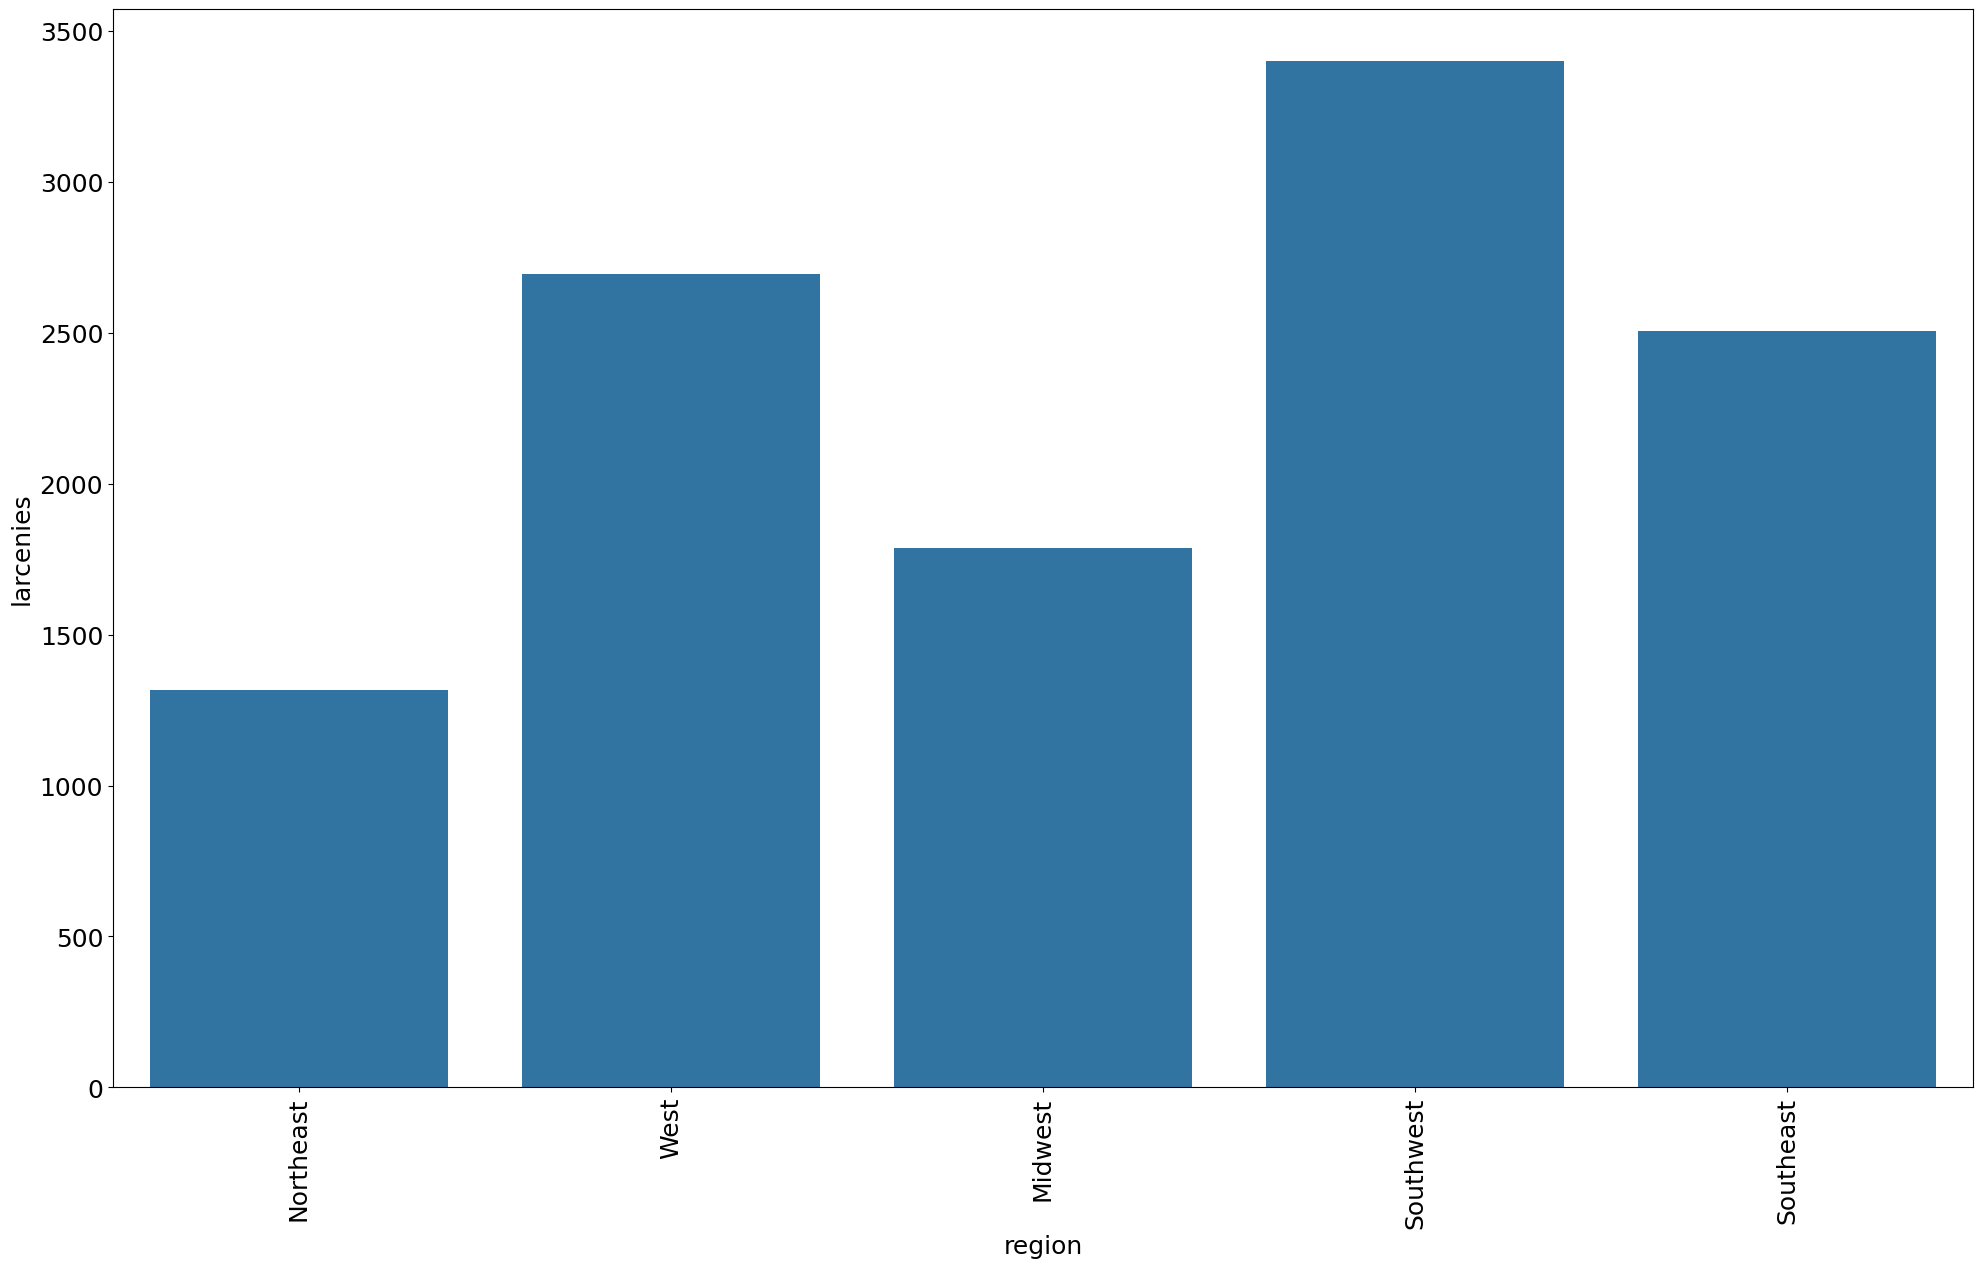

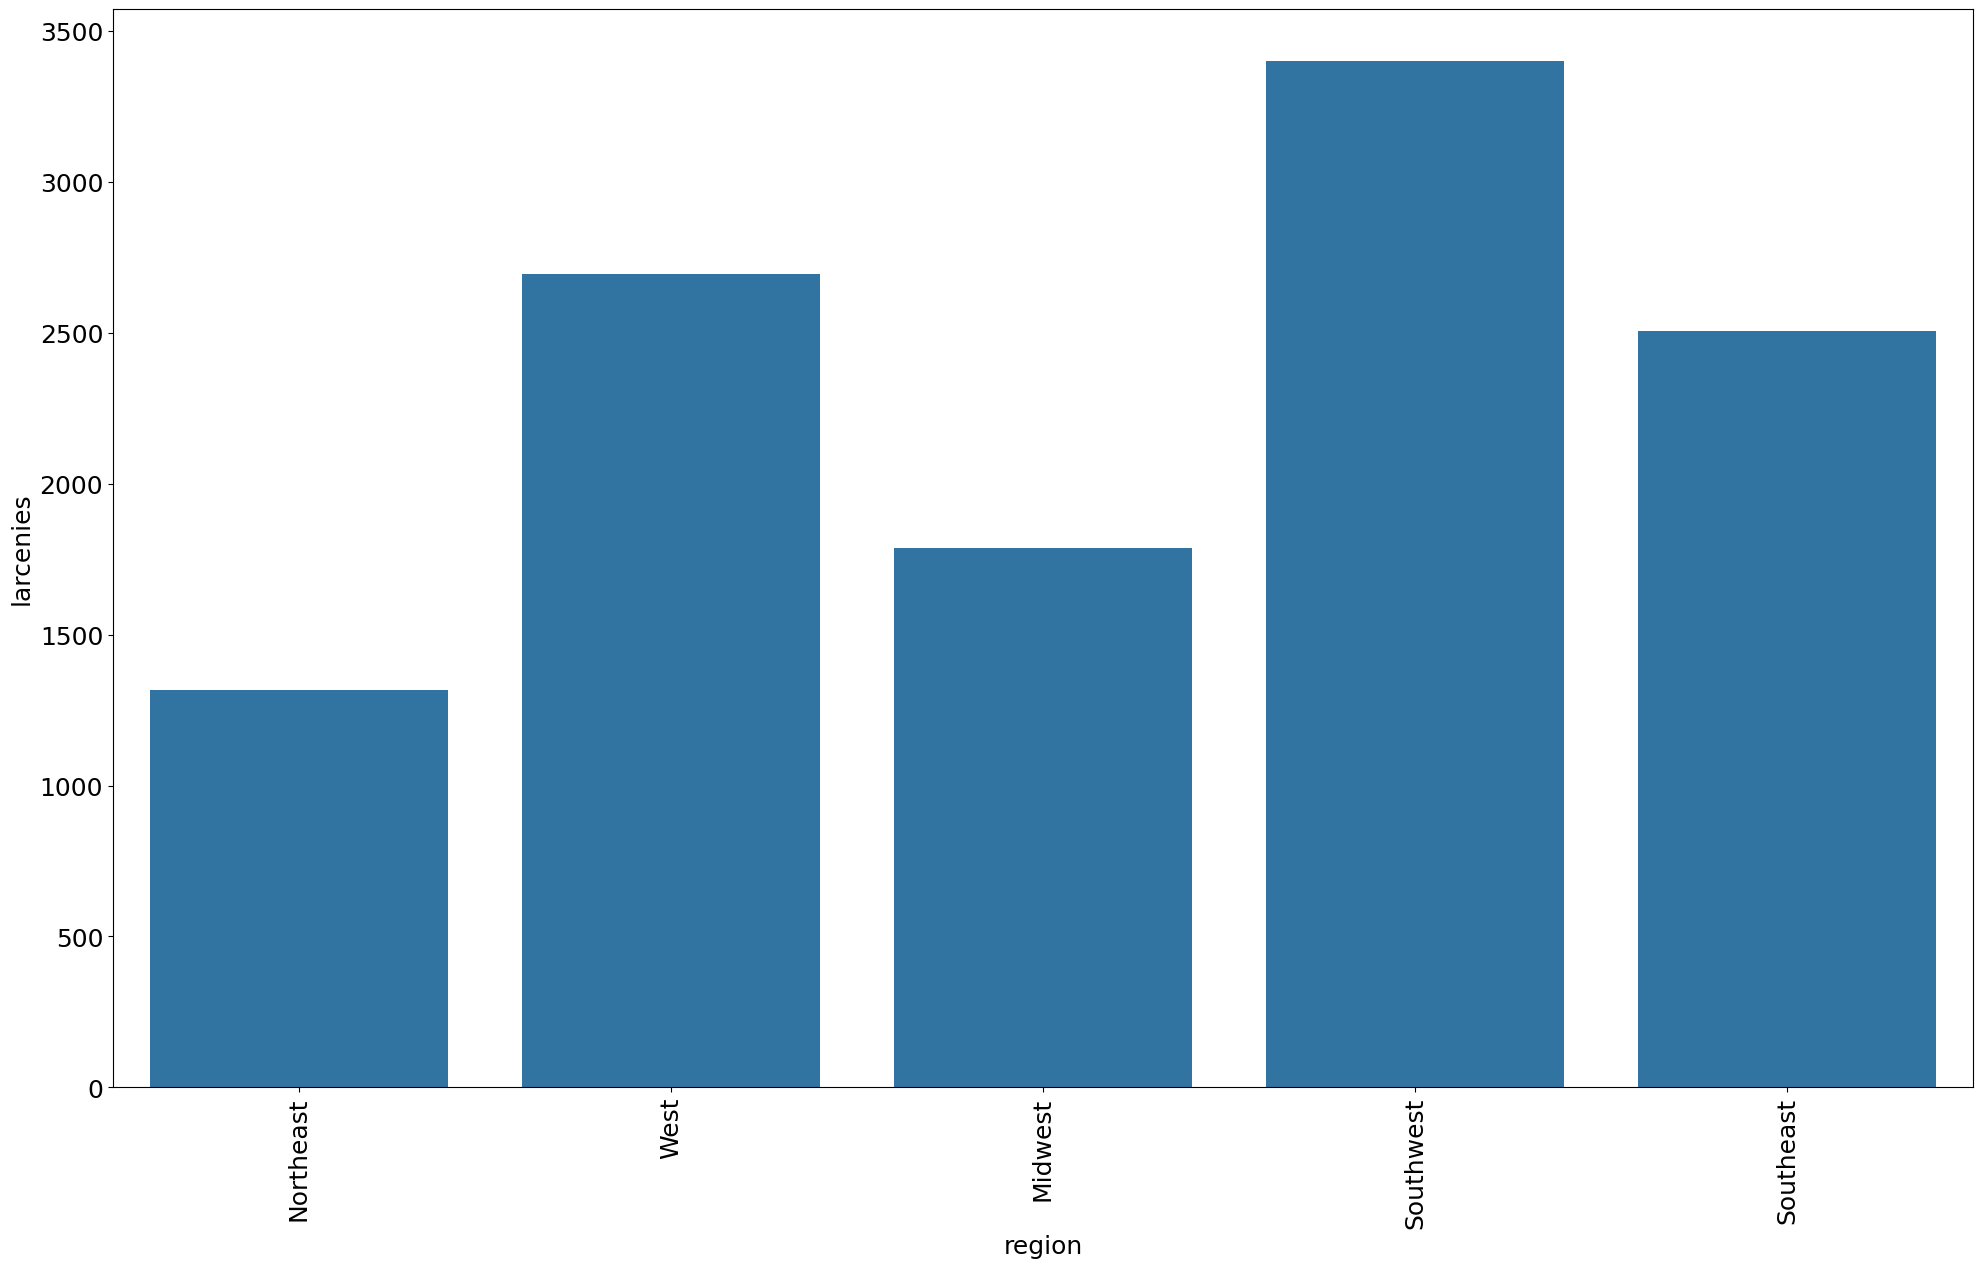

In [331]:
def plot_barplot(dataframe:pd.DataFrame, x:str, y:str=None, title:str=None, by:str=None, errorbar: tuple|bool=None, xtick_rotation:int=0, figsize:tuple=(12, 7)):
    plt.figure(figsize=figsize)
    sns.barplot(
        data=dataframe,
        x=x,
        y=y,
        hue=by,
        errorbar=errorbar
    )
    plt.title(title)
    plt.xlabel(x)
    if y != None:
        plt.ylabel(y)
    plt.xticks(rotation=xtick_rotation)
    plt.show()
### Auto theft vs Region
plot_barplot(dataframe=crime_df, x="region", y="autoTheft", figsize=(24, 14))
plot_barplot(dataframe=crime_df, x="region", y="larcenies", xtick_rotation=90, figsize=(24, 14))
plot_barplot(dataframe=crime_df, x="region", y="larcenies", xtick_rotation=90, figsize=(24, 14))


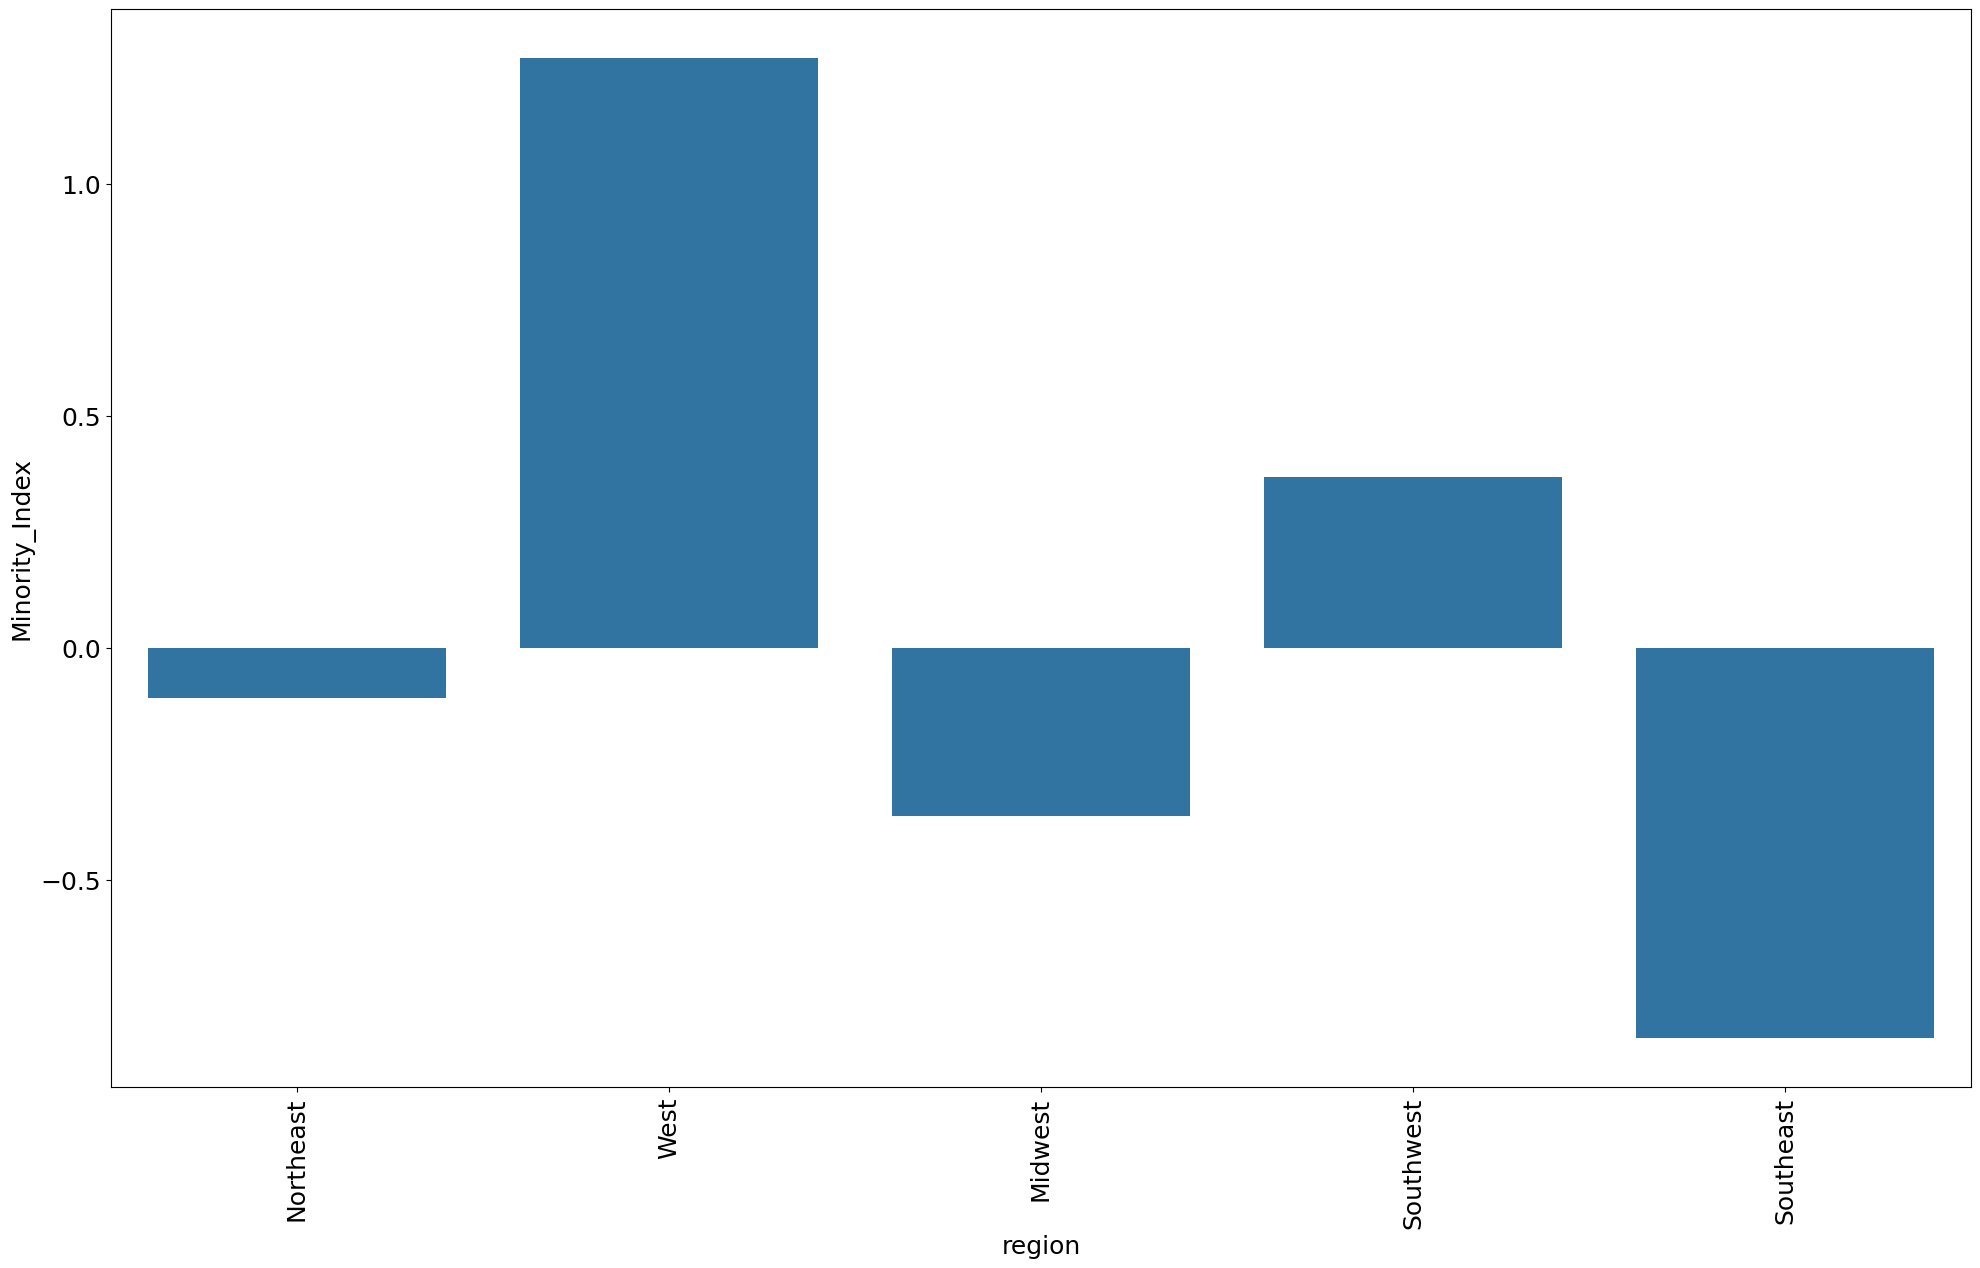

In [332]:
plot_barplot(dataframe=crime_df, x="region", y="Minority_Index", xtick_rotation=90, figsize=(24, 14))

In [333]:
# One-hot encode the regions column
crime_df['region'] = crime_df['region'].astype('category')
crime_df['region'] = crime_df['region'].cat.codes

In [334]:
crime_df['Minority_Index_binned'] = crime_df['Minority_Index_binned'].astype('category')
crime_df['Minority_Index_binned'] = crime_df['Minority_Index_binned'].cat.codes

In [335]:
from sklearn.preprocessing import OrdinalEncoder

num_quantiles = 4  # Quartiles
quantile_labels = ['Low', 'Medium-Low', 'Medium-High', 'High']

# Apply qcut
crime_df['PctUnemployed_binned'] = pd.qcut(
    crime_df['PctUnemployed'],
    q=num_quantiles,
    labels=quantile_labels,
    retbins=False,
    duplicates='drop'
)

# Encode using OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=[quantile_labels])
crime_df['PctUnemployed_binned_enc'] = ordinal_encoder.fit_transform(
    crime_df[['PctUnemployed_binned']]
)
crime_df['PctUnemployed_binned_enc'] = crime_df['PctUnemployed_binned_enc'].astype(int)

# Verify
crime_df.head()

C:\Users\riain\AppData\Local\Temp\ipykernel_30688\1341289501.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  crime_df['PctUnemployed_binned'] = pd.qcut(
C:\Users\riain\AppData\Local\Temp\ipykernel_30688\1341289501.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  crime_df['PctUnemployed_binned_enc'] = ordinal_encoder.fit_transform(


,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,FemalePctDiv,TotalPctDiv,PersPerFam,PctFam2Par,PctKids2Par,PctYoungKids2Par,PctTeen2Par,PctWorkMomYoungKids,PctWorkMom,NumKidsBornNeverMar,PctKidsBornNeverMar,NumImmig,PctImmigRecent,PctImmigRec5,PctImmigRec8,PctImmigRec10,PctRecentImmig,PctRecImmig5,PctRecImmig8,PctRecImmig10,PctSpeakEnglOnly,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,OwnOccQrange,RentLowQ,RentMedian,RentHighQ,RentQrange,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,murders,murdPerPop,rapes,rapesPerPop,robberies,robbbPerPop,assaults,assaultPerPop,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop,region,Minority_Index,Minority_Index_binned,PctUnemployed_binned,PctUnemployed_binned_enc
0,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,11.33,11980,100.0,75122,89.24,1.55,70.20,23.62,1.03,18.39,79584,29711,30233,13600,5725,27101,5115.0,22838,227,1.96,5.81,9.90,48.18,2.70,64.55,14.65,28.82,5.49,50.73,3.67,26.38,5.22,4.47,3.22,91.43,90.17,95.78,95.81,44.56,58.88,31,0.36,1277,8.69,13.00,20.99,30.93,0.93,1.39,2.24,3.30,85.68,1.37,4.81,4.17,2.99,3.00,2.84,91.46,0.39,11.06,3,64,98.37,91.01,3.12,37.50,1959,0.00,0.28,215900,262600,326900,111000,685,1001,1001,316,1001,23.8,21.1,14.0,11,0,10.66,53.72,65.29,78.09,89.14,6.5,1845.9,9.63,0.0,0,0.0,0.0,0.00,1.0,8.20,4.0,32.81,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59,1,0.453524,2,Low,0
1,23123,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,17.18,23123,100.0,47917,78.99,1.11,64.11,35.50,2.75,22.85,55323,20148,20191,18137,0,20074,5250.0,12222,885,3.98,5.61,13.72,29.89,2.43,61.96,12.26,29.28,6.39,37.64,4.23,27.99,6.45,5.42,3.11,86.91,85.33,96.82,86.46,51.14,62.43,43,0.24,1920,5.21,8.65,13.33,22.50,0.43,0.72,1.11,1.87,87.79,1.81,4.25,3.34,2.70,2.83,1.96,89.03,1.01,23.60,3,240,97.15,84.88,0.00,18.33,1958,0.31,0.14,136300,164200,199900,63600,467,560,672,205,627,27.6,20.7,12.5,0,0,8.30,77.17,71.27,90.22,96.12,10.6,2186.7,3.84,0.0,0,0.0,1.0,4.25,5.0,21.26,24.0,102.05,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95,1,-0.097546,1,Low,0
2,29344,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,10.28,29344,100.0,35669,82.00,1.15,55.73,22.25,2.94,14.56,42112,16946,17103,16644,21606,15528,5954.0,8405,1389,4.75,2.80,9.09,30.13,4.01,69.80,15.95,21.52,8.79,32.48,10.10,25.78,14.76,12.55,2.95,78.54,78.85,92.37,75.72,66.08,74.19,164,0.88,1468,16.42,23.98,32.08,35.63,0.82,1.20,1.61,1.78,93.11,1.14,2.97,2.05,2.42,2.69,2.06,64.18,2.03,47.46,3,544,95.68,57.79,0.92,7.54,1976,1.55,0.12,74700,90400,112000,37300,370,428,520,150,484,24.1,21.7,11.6,16,0,5.00,44.77,36.60,61.26,82.85,10.6,2780.9,4.37,0.0,3,8.3,6.0,16.60,56.0,154.95,14.0,38.74,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,218.59,6167.51,4,0.248827,2,Low,0
3,16656,2.40,1.70,97.35,0.50,0.70,12.55,25.20,12.19,17.57,0,0.0,20580,68.15,0.24,38.95,39.48,11.71,18.33,26501,10810,10909,9984,4941,3541,2451.0,4391,2831,17.23,11.05,33.68,10.81,9.86,54.74,31.22,27.43,26.76,22.71,10.98,28.15,14.47,12.91,2.98,64.02,62.36,65.38,67.43,59.59,70.27,561,3.84,339,13.86,13.86,15.34,15.34,

In [336]:
crime_df = crime_df.drop(["Minority_Index", "PctUnemployed_binned"], axis=1)
crime_df.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,FemalePctDiv,TotalPctDiv,PersPerFam,PctFam2Par,PctKids2Par,PctYoungKids2Par,PctTeen2Par,PctWorkMomYoungKids,PctWorkMom,NumKidsBornNeverMar,PctKidsBornNeverMar,NumImmig,PctImmigRecent,PctImmigRec5,PctImmigRec8,PctImmigRec10,PctRecentImmig,PctRecImmig5,PctRecImmig8,PctRecImmig10,PctSpeakEnglOnly,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,OwnOccQrange,RentLowQ,RentMedian,RentHighQ,RentQrange,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,murders,murdPerPop,rapes,rapesPerPop,robberies,robbbPerPop,assaults,assaultPerPop,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop,region,Minority_Index_binned,PctUnemployed_binned_enc
0,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,11.33,11980,100.0,75122,89.24,1.55,70.20,23.62,1.03,18.39,79584,29711,30233,13600,5725,27101,5115.0,22838,227,1.96,5.81,9.90,48.18,2.70,64.55,14.65,28.82,5.49,50.73,3.67,26.38,5.22,4.47,3.22,91.43,90.17,95.78,95.81,44.56,58.88,31,0.36,1277,8.69,13.00,20.99,30.93,0.93,1.39,2.24,3.30,85.68,1.37,4.81,4.17,2.99,3.00,2.84,91.46,0.39,11.06,3,64,98.37,91.01,3.12,37.50,1959,0.00,0.28,215900,262600,326900,111000,685,1001,1001,316,1001,23.8,21.1,14.0,11,0,10.66,53.72,65.29,78.09,89.14,6.5,1845.9,9.63,0.0,0,0.0,0.0,0.00,1.0,8.20,4.0,32.81,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59,1,2,0
1,23123,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,17.18,23123,100.0,47917,78.99,1.11,64.11,35.50,2.75,22.85,55323,20148,20191,18137,0,20074,5250.0,12222,885,3.98,5.61,13.72,29.89,2.43,61.96,12.26,29.28,6.39,37.64,4.23,27.99,6.45,5.42,3.11,86.91,85.33,96.82,86.46,51.14,62.43,43,0.24,1920,5.21,8.65,13.33,22.50,0.43,0.72,1.11,1.87,87.79,1.81,4.25,3.34,2.70,2.83,1.96,89.03,1.01,23.60,3,240,97.15,84.88,0.00,18.33,1958,0.31,0.14,136300,164200,199900,63600,467,560,672,205,627,27.6,20.7,12.5,0,0,8.30,77.17,71.27,90.22,96.12,10.6,2186.7,3.84,0.0,0,0.0,1.0,4.25,5.0,21.26,24.0,102.05,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95,1,1,0
2,29344,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,10.28,29344,100.0,35669,82.00,1.15,55.73,22.25,2.94,14.56,42112,16946,17103,16644,21606,15528,5954.0,8405,1389,4.75,2.80,9.09,30.13,4.01,69.80,15.95,21.52,8.79,32.48,10.10,25.78,14.76,12.55,2.95,78.54,78.85,92.37,75.72,66.08,74.19,164,0.88,1468,16.42,23.98,32.08,35.63,0.82,1.20,1.61,1.78,93.11,1.14,2.97,2.05,2.42,2.69,2.06,64.18,2.03,47.46,3,544,95.68,57.79,0.92,7.54,1976,1.55,0.12,74700,90400,112000,37300,370,428,520,150,484,24.1,21.7,11.6,16,0,5.00,44.77,36.60,61.26,82.85,10.6,2780.9,4.37,0.0,3,8.3,6.0,16.60,56.0,154.95,14.0,38.74,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,218.59,6167.51,4,2,0
3,16656,2.40,1.70,97.35,0.50,0.70,12.55,25.20,12.19,17.57,0,0.0,20580,68.15,0.24,38.95,39.48,11.71,18.33,26501,10810,10909,9984,4941,3541,2451.0,4391,2831,17.23,11.05,33.68,10.81,9.86,54.74,31.22,27.43,26.76,22.71,10.98,28.15,14.47,12.91,2.98,64.02,62.36,65.38,67.43,59.59,70.27,561,3.84,339,13.86,13.86,15.34,15.34,0.28,0.28,0.31,0.31,94.98,0.56,3.93,2.56,2.37,2.51,2.20,58.18,1.21,45.66,3,6

In [337]:
num_bins = 5  # Quintiles
bin_labels = [f'Q{i}' for i in range(1, num_bins + 1)]

crime_df['PctRecImmig5_binned'], bin_edges = pd.qcut(
    crime_df['PctRecImmig5'],
    q=num_bins,
    labels=bin_labels,
    retbins=True,
    duplicates='drop'
)
actual_bins = len(bin_edges) - 1

crime_df.head()

C:\Users\riain\AppData\Local\Temp\ipykernel_30688\1207579101.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  crime_df['PctRecImmig5_binned'], bin_edges = pd.qcut(


,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,FemalePctDiv,TotalPctDiv,PersPerFam,PctFam2Par,PctKids2Par,PctYoungKids2Par,PctTeen2Par,PctWorkMomYoungKids,PctWorkMom,NumKidsBornNeverMar,PctKidsBornNeverMar,NumImmig,PctImmigRecent,PctImmigRec5,PctImmigRec8,PctImmigRec10,PctRecentImmig,PctRecImmig5,PctRecImmig8,PctRecImmig10,PctSpeakEnglOnly,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,OwnOccQrange,RentLowQ,RentMedian,RentHighQ,RentQrange,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,murders,murdPerPop,rapes,rapesPerPop,robberies,robbbPerPop,assaults,assaultPerPop,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop,region,Minority_Index_binned,PctUnemployed_binned_enc,PctRecImmig5_binned
0,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,11.33,11980,100.0,75122,89.24,1.55,70.20,23.62,1.03,18.39,79584,29711,30233,13600,5725,27101,5115.0,22838,227,1.96,5.81,9.90,48.18,2.70,64.55,14.65,28.82,5.49,50.73,3.67,26.38,5.22,4.47,3.22,91.43,90.17,95.78,95.81,44.56,58.88,31,0.36,1277,8.69,13.00,20.99,30.93,0.93,1.39,2.24,3.30,85.68,1.37,4.81,4.17,2.99,3.00,2.84,91.46,0.39,11.06,3,64,98.37,91.01,3.12,37.50,1959,0.00,0.28,215900,262600,326900,111000,685,1001,1001,316,1001,23.8,21.1,14.0,11,0,10.66,53.72,65.29,78.09,89.14,6.5,1845.9,9.63,0.0,0,0.0,0.0,0.00,1.0,8.20,4.0,32.81,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59,1,2,0,Q4
1,23123,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,17.18,23123,100.0,47917,78.99,1.11,64.11,35.50,2.75,22.85,55323,20148,20191,18137,0,20074,5250.0,12222,885,3.98,5.61,13.72,29.89,2.43,61.96,12.26,29.28,6.39,37.64,4.23,27.99,6.45,5.42,3.11,86.91,85.33,96.82,86.46,51.14,62.43,43,0.24,1920,5.21,8.65,13.33,22.50,0.43,0.72,1.11,1.87,87.79,1.81,4.25,3.34,2.70,2.83,1.96,89.03,1.01,23.60,3,240,97.15,84.88,0.00,18.33,1958,0.31,0.14,136300,164200,199900,63600,467,560,672,205,627,27.6,20.7,12.5,0,0,8.30,77.17,71.27,90.22,96.12,10.6,2186.7,3.84,0.0,0,0.0,1.0,4.25,5.0,21.26,24.0,102.05,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95,1,1,0,Q3
2,29344,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,10.28,29344,100.0,35669,82.00,1.15,55.73,22.25,2.94,14.56,42112,16946,17103,16644,21606,15528,5954.0,8405,1389,4.75,2.80,9.09,30.13,4.01,69.80,15.95,21.52,8.79,32.48,10.10,25.78,14.76,12.55,2.95,78.54,78.85,92.37,75.72,66.08,74.19,164,0.88,1468,16.42,23.98,32.08,35.63,0.82,1.20,1.61,1.78,93.11,1.14,2.97,2.05,2.42,2.69,2.06,64.18,2.03,47.46,3,544,95.68,57.79,0.92,7.54,1976,1.55,0.12,74700,90400,112000,37300,370,428,520,150,484,24.1,21.7,11.6,16,0,5.00,44.77,36.60,61.26,82.85,10.6,2780.9,4.37,0.0,3,8.3,6.0,16.60,56.0,154.95,14.0,38.74,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,218.59,6167.51,4,2,0,Q4
3,16656,2.40,1.70,97.35,0.50,0.70,12.55,25.20,12.19,17.57,0,0.0,20580,68.15,0.24,38.95,39.48,11.71,18.33,26501,10810,10909,9984,4941,3541,2451.0,4391,2831,17.23,11.05,33.68,10.81,9.86,54.74,31.22,27.43,26.76,22.71,10.98,28.15,14.47,12.91,2.98,64.02,62.36,65.38,67.43,59.59,70.27,561,3.84,339,13.86,13.86,15.34,15.34,0.28,0.28,0.31,0.31,94.98,0.56,3.93,2.56,2.37,2

In [338]:
crime_df["PctRecImmig5_binned"].value_counts()

PctRecImmig5_binned
Q1    456
Q4    442
Q3    441
Q5    441
Q2    435
Name: count, dtype: int64

In [339]:
crime_df['PctRecImmig5_binned'] = crime_df['PctRecImmig5_binned'].astype('category')
crime_df['PctRecImmig5_binned'] = crime_df['PctRecImmig5_binned'].cat.codes

In [340]:
crime_df.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,FemalePctDiv,TotalPctDiv,PersPerFam,PctFam2Par,PctKids2Par,PctYoungKids2Par,PctTeen2Par,PctWorkMomYoungKids,PctWorkMom,NumKidsBornNeverMar,PctKidsBornNeverMar,NumImmig,PctImmigRecent,PctImmigRec5,PctImmigRec8,PctImmigRec10,PctRecentImmig,PctRecImmig5,PctRecImmig8,PctRecImmig10,PctSpeakEnglOnly,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,OwnOccQrange,RentLowQ,RentMedian,RentHighQ,RentQrange,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,murders,murdPerPop,rapes,rapesPerPop,robberies,robbbPerPop,assaults,assaultPerPop,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop,region,Minority_Index_binned,PctUnemployed_binned_enc,PctRecImmig5_binned
0,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,11.33,11980,100.0,75122,89.24,1.55,70.20,23.62,1.03,18.39,79584,29711,30233,13600,5725,27101,5115.0,22838,227,1.96,5.81,9.90,48.18,2.70,64.55,14.65,28.82,5.49,50.73,3.67,26.38,5.22,4.47,3.22,91.43,90.17,95.78,95.81,44.56,58.88,31,0.36,1277,8.69,13.00,20.99,30.93,0.93,1.39,2.24,3.30,85.68,1.37,4.81,4.17,2.99,3.00,2.84,91.46,0.39,11.06,3,64,98.37,91.01,3.12,37.50,1959,0.00,0.28,215900,262600,326900,111000,685,1001,1001,316,1001,23.8,21.1,14.0,11,0,10.66,53.72,65.29,78.09,89.14,6.5,1845.9,9.63,0.0,0,0.0,0.0,0.00,1.0,8.20,4.0,32.81,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59,1,2,0,3
1,23123,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,17.18,23123,100.0,47917,78.99,1.11,64.11,35.50,2.75,22.85,55323,20148,20191,18137,0,20074,5250.0,12222,885,3.98,5.61,13.72,29.89,2.43,61.96,12.26,29.28,6.39,37.64,4.23,27.99,6.45,5.42,3.11,86.91,85.33,96.82,86.46,51.14,62.43,43,0.24,1920,5.21,8.65,13.33,22.50,0.43,0.72,1.11,1.87,87.79,1.81,4.25,3.34,2.70,2.83,1.96,89.03,1.01,23.60,3,240,97.15,84.88,0.00,18.33,1958,0.31,0.14,136300,164200,199900,63600,467,560,672,205,627,27.6,20.7,12.5,0,0,8.30,77.17,71.27,90.22,96.12,10.6,2186.7,3.84,0.0,0,0.0,1.0,4.25,5.0,21.26,24.0,102.05,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95,1,1,0,2
2,29344,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,10.28,29344,100.0,35669,82.00,1.15,55.73,22.25,2.94,14.56,42112,16946,17103,16644,21606,15528,5954.0,8405,1389,4.75,2.80,9.09,30.13,4.01,69.80,15.95,21.52,8.79,32.48,10.10,25.78,14.76,12.55,2.95,78.54,78.85,92.37,75.72,66.08,74.19,164,0.88,1468,16.42,23.98,32.08,35.63,0.82,1.20,1.61,1.78,93.11,1.14,2.97,2.05,2.42,2.69,2.06,64.18,2.03,47.46,3,544,95.68,57.79,0.92,7.54,1976,1.55,0.12,74700,90400,112000,37300,370,428,520,150,484,24.1,21.7,11.6,16,0,5.00,44.77,36.60,61.26,82.85,10.6,2780.9,4.37,0.0,3,8.3,6.0,16.60,56.0,154.95,14.0,38.74,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,218.59,6167.51,4,2,0,3
3,16656,2.40,1.70,97.35,0.50,0.70,12.55,25.20,12.19,17.57,0,0.0,20580,68.15,0.24,38.95,39.48,11.71,18.33,26501,10810,10909,9984,4941,3541,2451.0,4391,2831,17.23,11.05,33.68,10.81,9.86,54.74,31.22,27.43,26.76,22.71,10.98,28.15,14.47,12.91,2.98,64.02,62.36,65.38,67.43,59.59,70.27,561,3.84,339,13.86,13.86,15.34,15.34,0.28,0.28,0.31,0.31,94.98,0.56,3.93,2.56,2.37,2.51

In [341]:
outliers_dict = {}
bins = 5

In [342]:
# Detect and handle outliers (Optional)
# For simplicity, we'll cap outliers at the 1st and 99th percentiles
for col in numerical_cols:
    lower_cap = crime_df[col].quantile(0.01)
    upper_cap = crime_df[col].quantile(0.99)
    crime_df[col] = np.where(crime_df[col] < lower_cap, lower_cap, crime_df[col])
    crime_df[col] = np.where(crime_df[col] > upper_cap, upper_cap, crime_df[col])

## Bivariate Analysis
---

In [343]:
plt.rc('font', size=6)

C:\Users\riain\AppData\Local\Temp\ipykernel_30688\1340041629.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range_correlations.index, y=range_correlations.values, palette=colors)


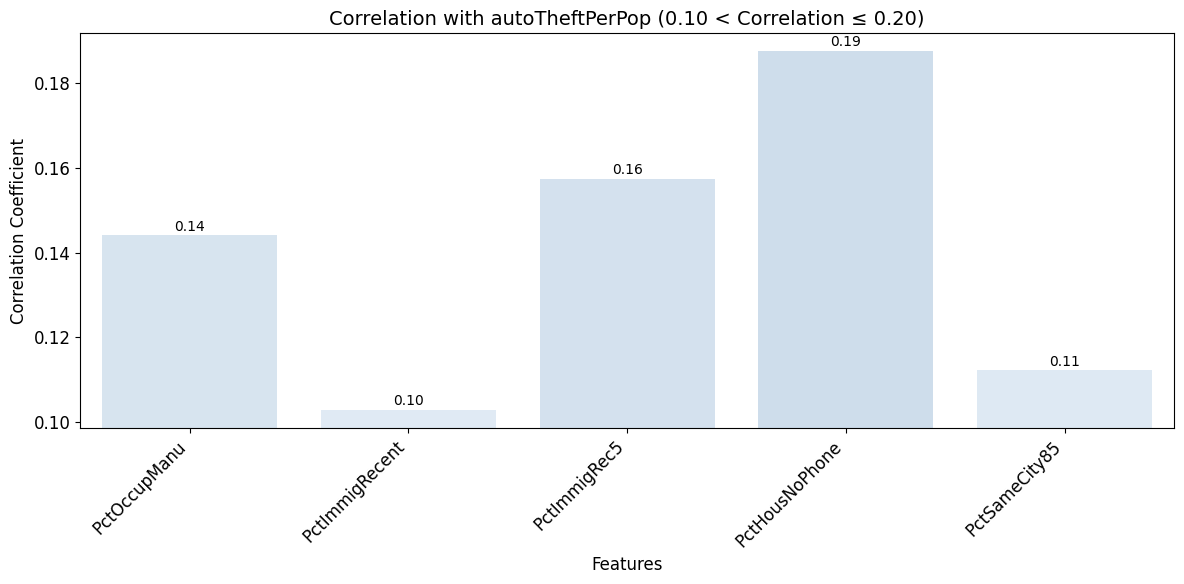

C:\Users\riain\AppData\Local\Temp\ipykernel_30688\1340041629.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range_correlations.index, y=range_correlations.values, palette=colors)


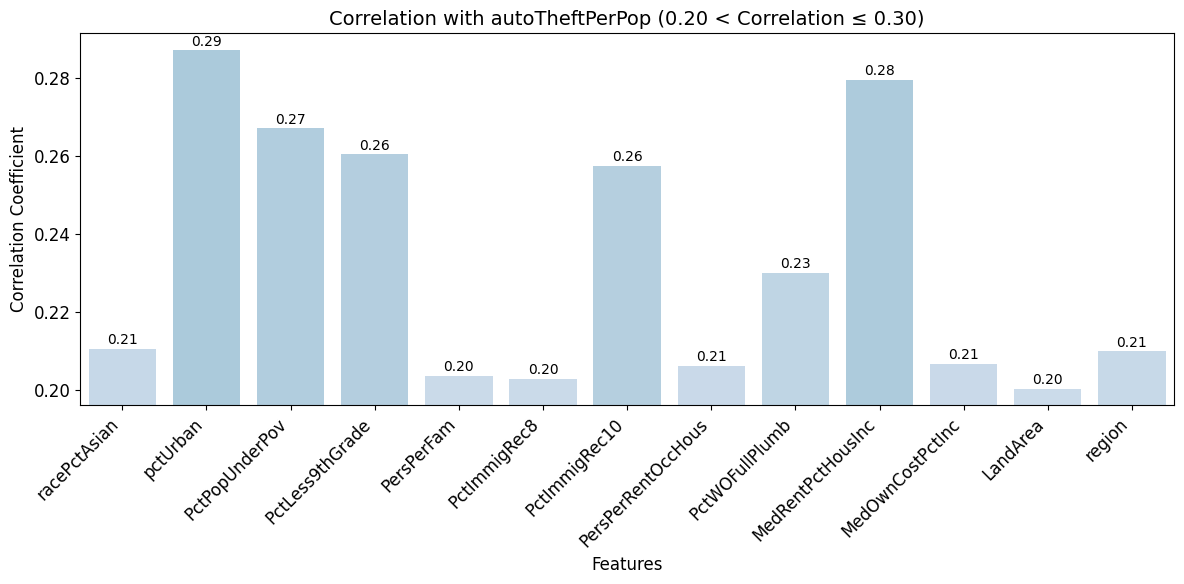

C:\Users\riain\AppData\Local\Temp\ipykernel_30688\1340041629.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range_correlations.index, y=range_correlations.values, palette=colors)


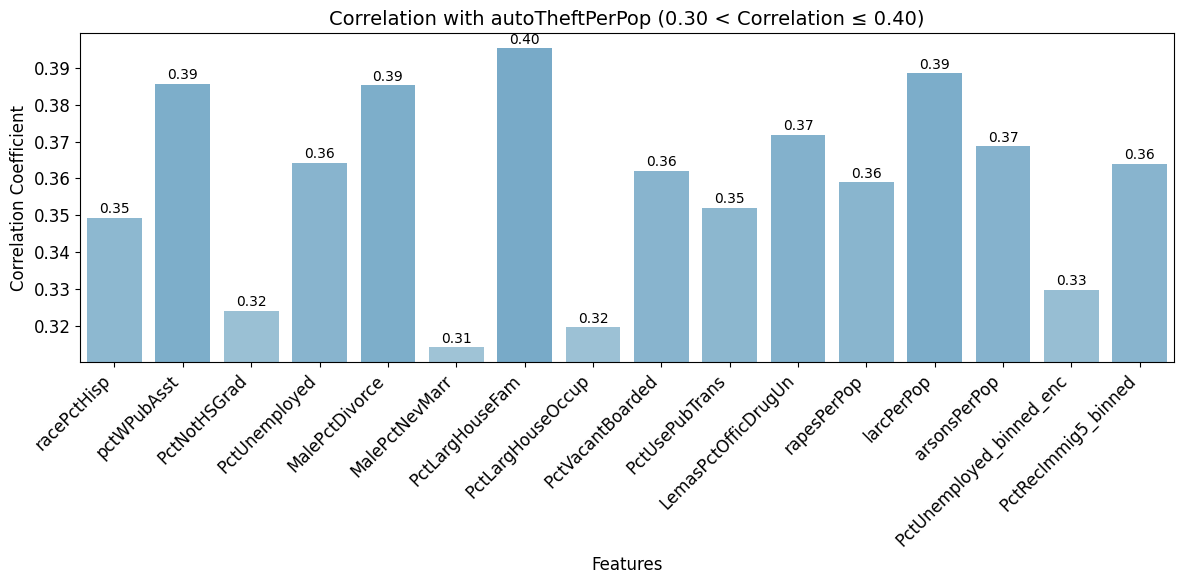

C:\Users\riain\AppData\Local\Temp\ipykernel_30688\1340041629.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range_correlations.index, y=range_correlations.values, palette=colors)


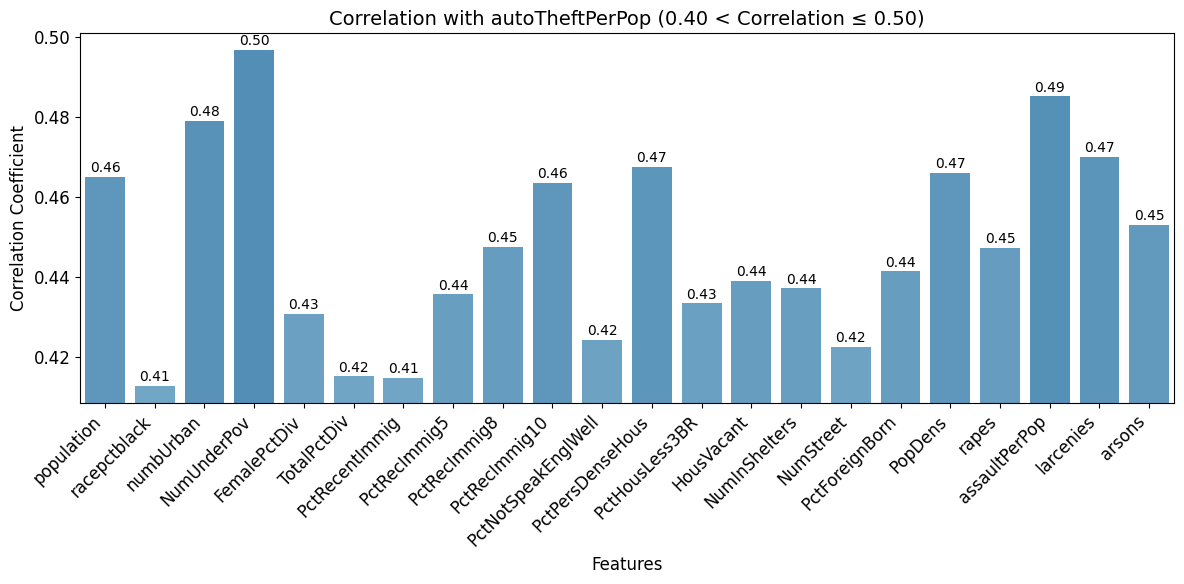

C:\Users\riain\AppData\Local\Temp\ipykernel_30688\1340041629.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range_correlations.index, y=range_correlations.values, palette=colors)


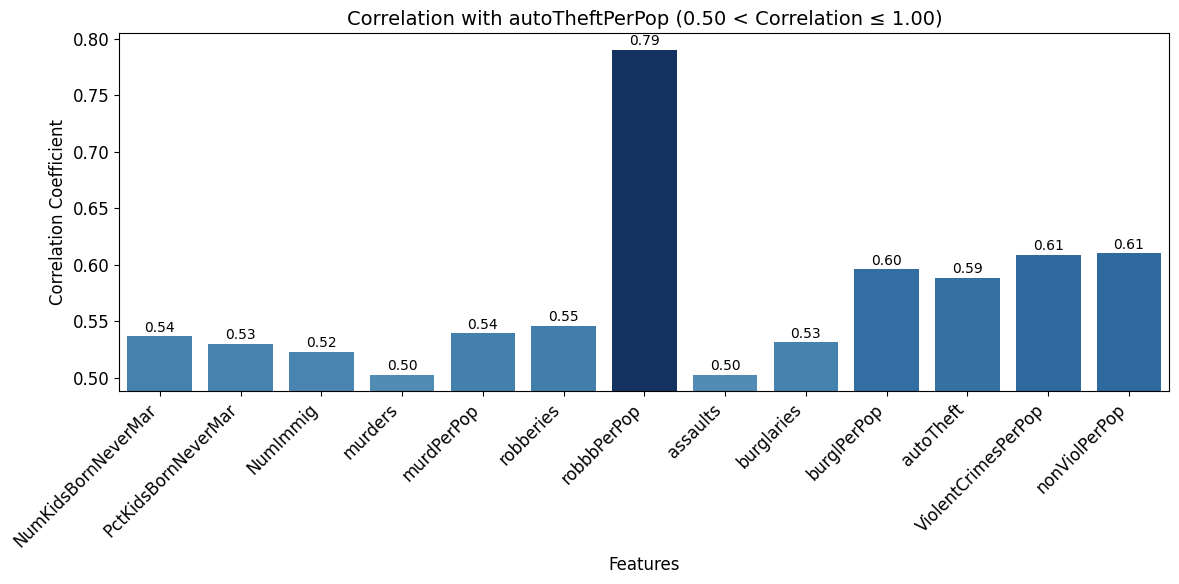

C:\Users\riain\AppData\Local\Temp\ipykernel_30688\1340041629.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range_correlations.index, y=range_correlations.values, palette=colors)


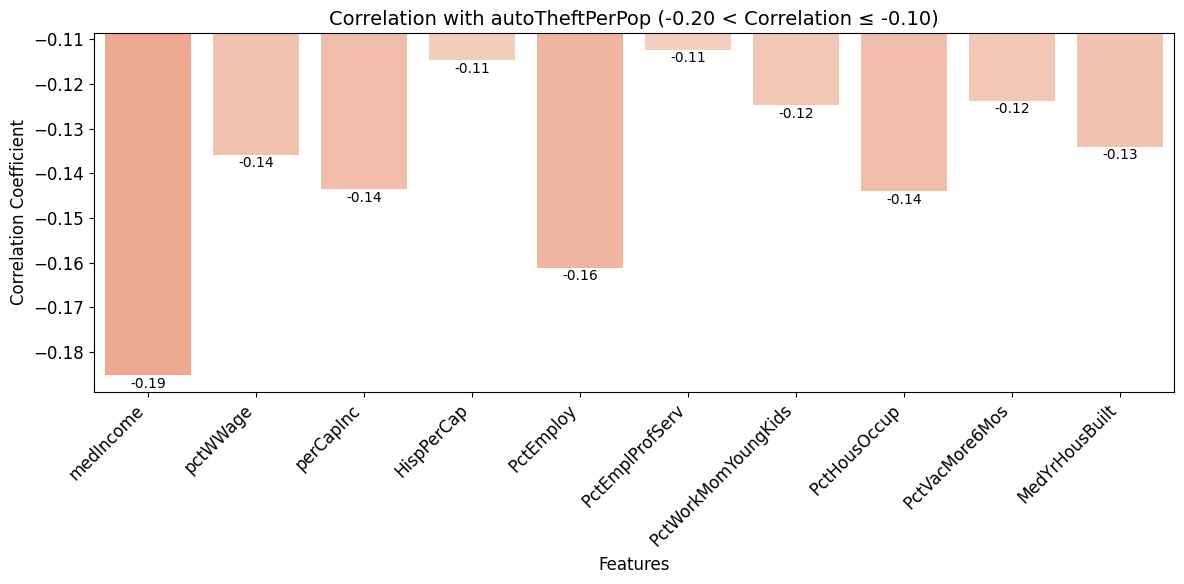

C:\Users\riain\AppData\Local\Temp\ipykernel_30688\1340041629.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range_correlations.index, y=range_correlations.values, palette=colors)


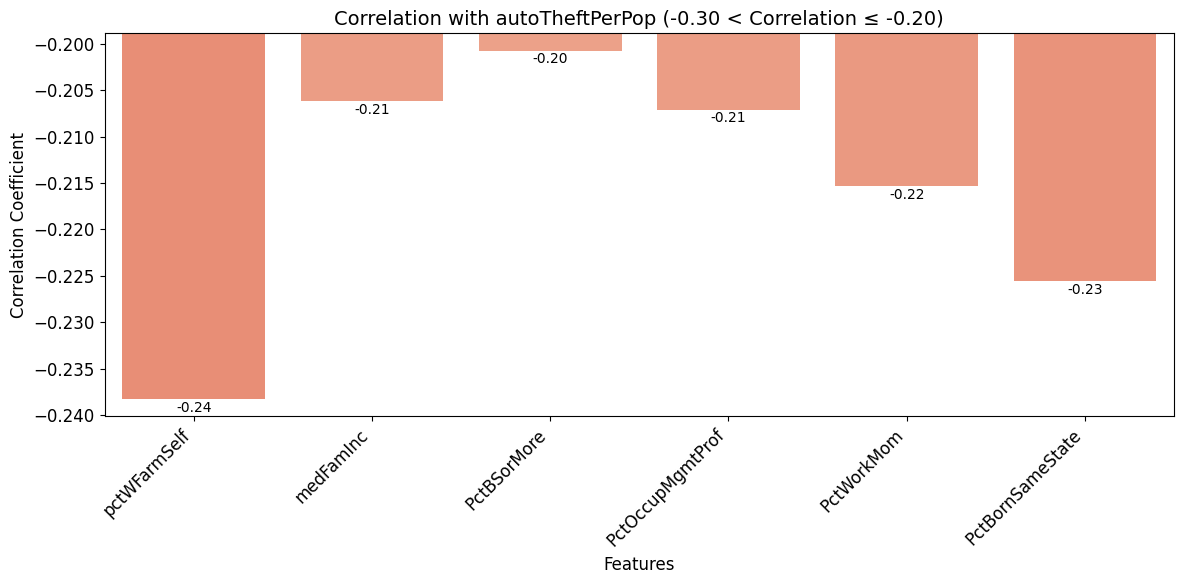

C:\Users\riain\AppData\Local\Temp\ipykernel_30688\1340041629.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range_correlations.index, y=range_correlations.values, palette=colors)


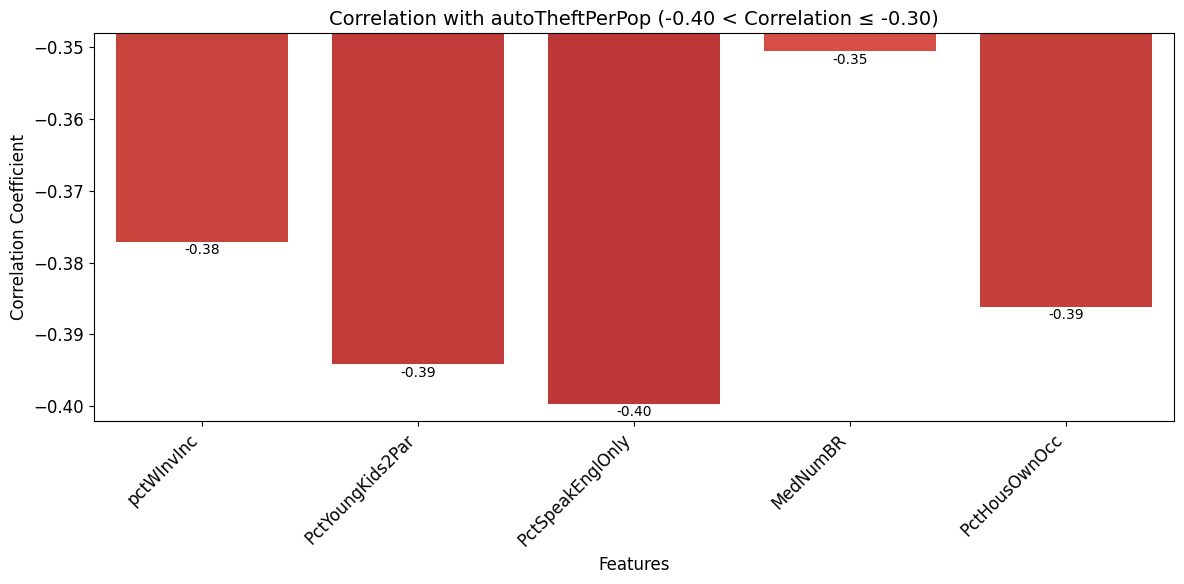

C:\Users\riain\AppData\Local\Temp\ipykernel_30688\1340041629.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range_correlations.index, y=range_correlations.values, palette=colors)


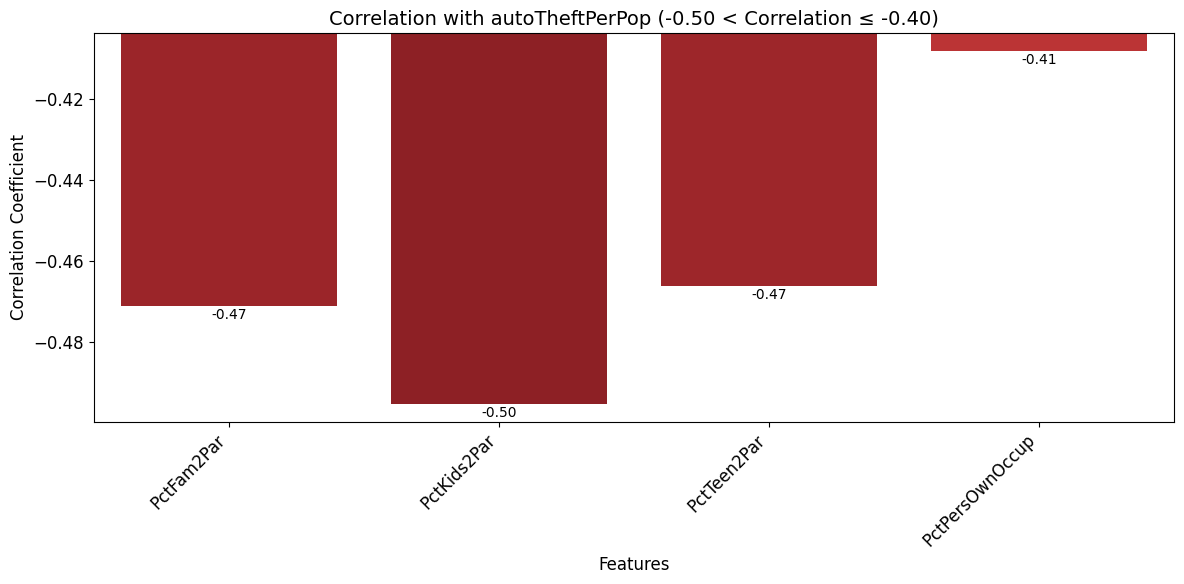

C:\Users\riain\AppData\Local\Temp\ipykernel_30688\1340041629.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range_correlations.index, y=range_correlations.values, palette=colors)


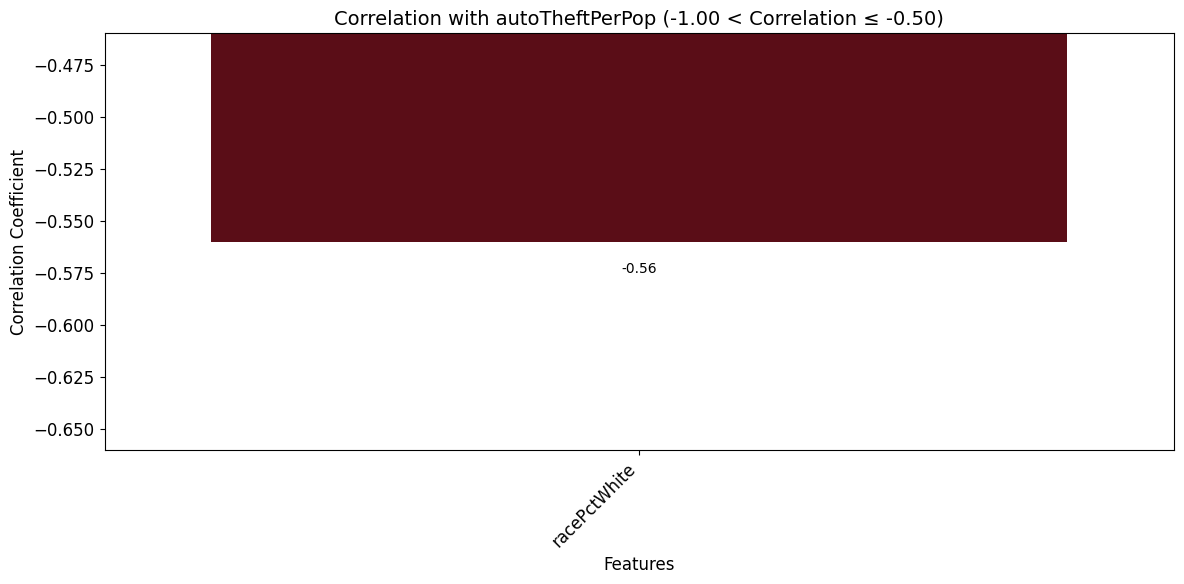

In [344]:
# Calculate correlations with 'autoTheftPerPop' excluding itself
correlations = crime_df.corr()['autoTheftPerPop'].drop('autoTheftPerPop')

# Define correlation ranges
ranges = [
    (0.10, 0.20), (0.20, 0.30), (0.30, 0.40), (0.40, 0.50), (0.50, 1.00),
    (-0.20, -0.10), (-0.30, -0.20), (-0.40, -0.30), (-0.50, -0.40), (-1.00, -0.50)
]

# Set global font size
plt.rc('font', size=12)

# Define separate colormaps for positive and negative correlations
cmap_positive = plt.get_cmap('Blues')
cmap_negative = plt.get_cmap('Reds')

# Determine the maximum positive and negative correlations for normalization
max_pos = correlations[correlations > 0].max()
max_neg = abs(correlations[correlations < 0].min())

for lower, upper in ranges:
    # Filter correlations within the current range
    range_correlations = correlations[(correlations > lower) & (correlations <= upper)]
    
    if not range_correlations.empty:
        plt.figure(figsize=(12, 6))
        
        # Assign colors based on the sign and magnitude of the correlation
        colors = []
        for value in range_correlations.values:
            if value > 0:
                # Normalize value between 0 and max_pos for positive correlations
                normalized = value / max_pos if max_pos != 0 else 0
                colors.append(cmap_positive(normalized))
            else:
                # Normalize value between 0 and max_neg for negative correlations
                normalized = abs(value) / max_neg if max_neg != 0 else 0
                colors.append(cmap_negative(normalized))
        
        # Create barplot with custom colors
        sns.barplot(x=range_correlations.index, y=range_correlations.values, palette=colors)
        
        # Set y-axis limits to provide space for labels
        min_corr = range_correlations.values.min()
        max_corr = range_correlations.values.max()
        y_margin = 0.05 * (max_corr - min_corr) if (max_corr - min_corr) != 0 else 0.1
        plt.ylim(min_corr - y_margin, max_corr + y_margin)
        
        # Annotate each bar with the correlation value
        for i, value in enumerate(range_correlations.values):
            if value >= 0:
                # Positive correlation: place text slightly above the bar
                plt.text(i, value + y_margin * 0.1, f'{value:.2f}', ha='center', va='bottom', fontsize=10, color='black')
            else:
                # Negative correlation: place text slightly below the bar
                plt.text(i, value - y_margin * 0.1, f'{value:.2f}', ha='center', va='top', fontsize=10, color='black')
        
        # Set title and labels
        plt.title(f'Correlation with autoTheftPerPop ({lower:.2f} < Correlation ≤ {upper:.2f})', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Correlation Coefficient', fontsize=12)
        plt.xlabel('Features', fontsize=12)
        plt.tight_layout()
        plt.show()


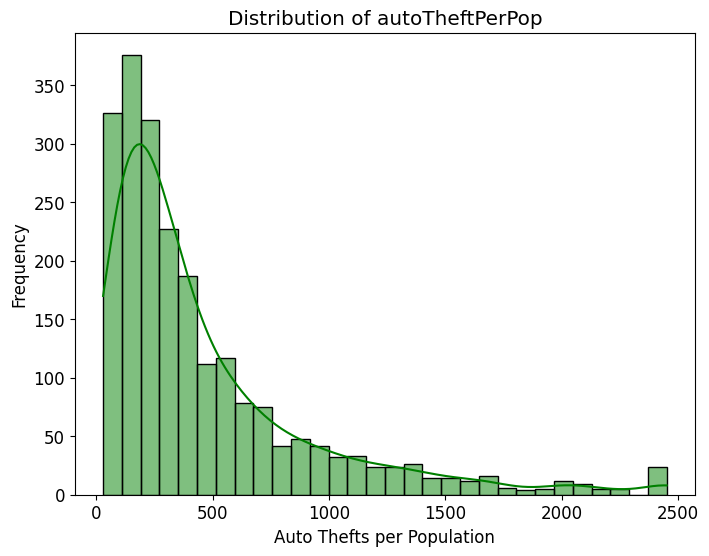

In [345]:
# Distribution of Target Variable
plt.figure(figsize=(8, 6))
sns.histplot(crime_df['autoTheftPerPop'], kde=True, bins=30, color='green')
plt.title('Distribution of autoTheftPerPop')
plt.xlabel('Auto Thefts per Population')
plt.ylabel('Frequency')
plt.show()

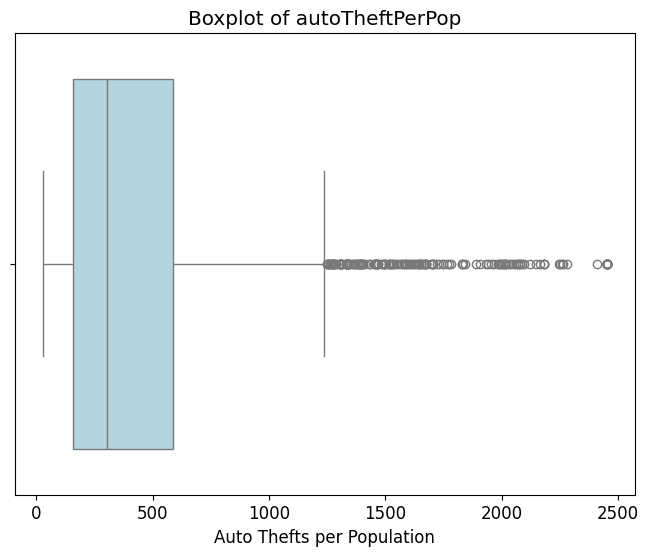

In [346]:
# Boxplot to identify outliers in target variable
plt.figure(figsize=(8, 6))
sns.boxplot(x=crime_df['autoTheftPerPop'], color='lightblue')
plt.title('Boxplot of autoTheftPerPop')
plt.xlabel('Auto Thefts per Population')
plt.show()

* PctUnemployed: Percentage of unemployed individuals (numeric)
* PctEmploy: Percentage of employed individuals (numeric)
* PctEmplManu: Percentage of people employed in manufacturing (numeric)
* PctEmplProfServ: Percentage of people employed in professional services (numeric)

* pctWWage: Percentage of households with wage/salary income in 1989 (numeric)
* pctWFarmSelf: Percentage of households with farm or self-employment income in 1989 (numeric)
* pctWInvInc: Percentage of households with investment income (numeric)
* pctWSocSec: Percentage of households with social security income (numeric)
* pctWPubAsst: Percentage of households with public assistance (numeric)
* pctWRetire: Percentage of households with retirement income (numeric)

* PctImmigRecent: Percentage of recent immigrants (within 3 years) (numeric)
* PctImmigRec5: Percentage of immigrants within the last 5 years (numeric)
* PctImmigRec8: Percentage of immigrants within the last 8 years (numeric)
* PctImmigRec10: Percentage of immigrants within the last 10 years (numeric)
* PctRecentImmig: Percentage of recent immigrants in the population (numeric)
* PctRecImmig5: Percentage of population who immigrated within the last 5 years (numeric)
* PctRecImmig8: Percentage of population who immigrated within the last 8 years (numeric)
* PctRecImmig10: Percentage of population who immigrated within the last 10 years (numeric)

* medIncome: Median household income (numeric)
* medFamInc: Median family income (numeric)

## Graph Correlation with Scatterplot
---

In [347]:
def linear_relationship_plot(dataframe: pd.DataFrame, x:str, y:list, title:str, ci:bool=False, n_rows:int=1, n_cols:int=1, sharex=True, sharey=True, xtick_rotation:int=0, figsize:tuple=(28, 14)) :
    fig, ax = plt.subplots(n_rows, n_cols, sharex=sharex, sharey=sharey, figsize=figsize)
    col_index = 0

    if n_rows>1 and n_cols>1:
        for i in range(n_rows):
            for j in range(n_cols):
                ax[i][j] = sns.regplot(data=dataframe, x=x, y=y[col_index], ax=ax[i][j], ci=ci, line_kws={"color":"red"})
                ax[i][j].tick_params(rotation=xtick_rotation)
                ax[i][j].set_title(f"{y[col_index]} vs {x}")
                ax[i][j].set(ylabel=None, xlabel=None)
                col_index += 1
    elif n_cols > 1:
        for j in range(n_cols):
            ax[j] = sns.regplot(data=dataframe, x=x, y=y[col_index], ax=ax[j], ci=ci, line_kws={"color":"red"})
            ax[j].tick_params(rotation=xtick_rotation)
            ax[j].set_title(f"{y[col_index]} vs {x}")
            ax[j].set(ylabel=None, xlabel=None)
            col_index += 1
    fig.suptitle(title)
    plt.tight_layout()
    fig.show()

In [348]:
plt.rcParams.update({"font.size":21})

C:\Users\riain\AppData\Local\Temp\ipykernel_30688\1068752479.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


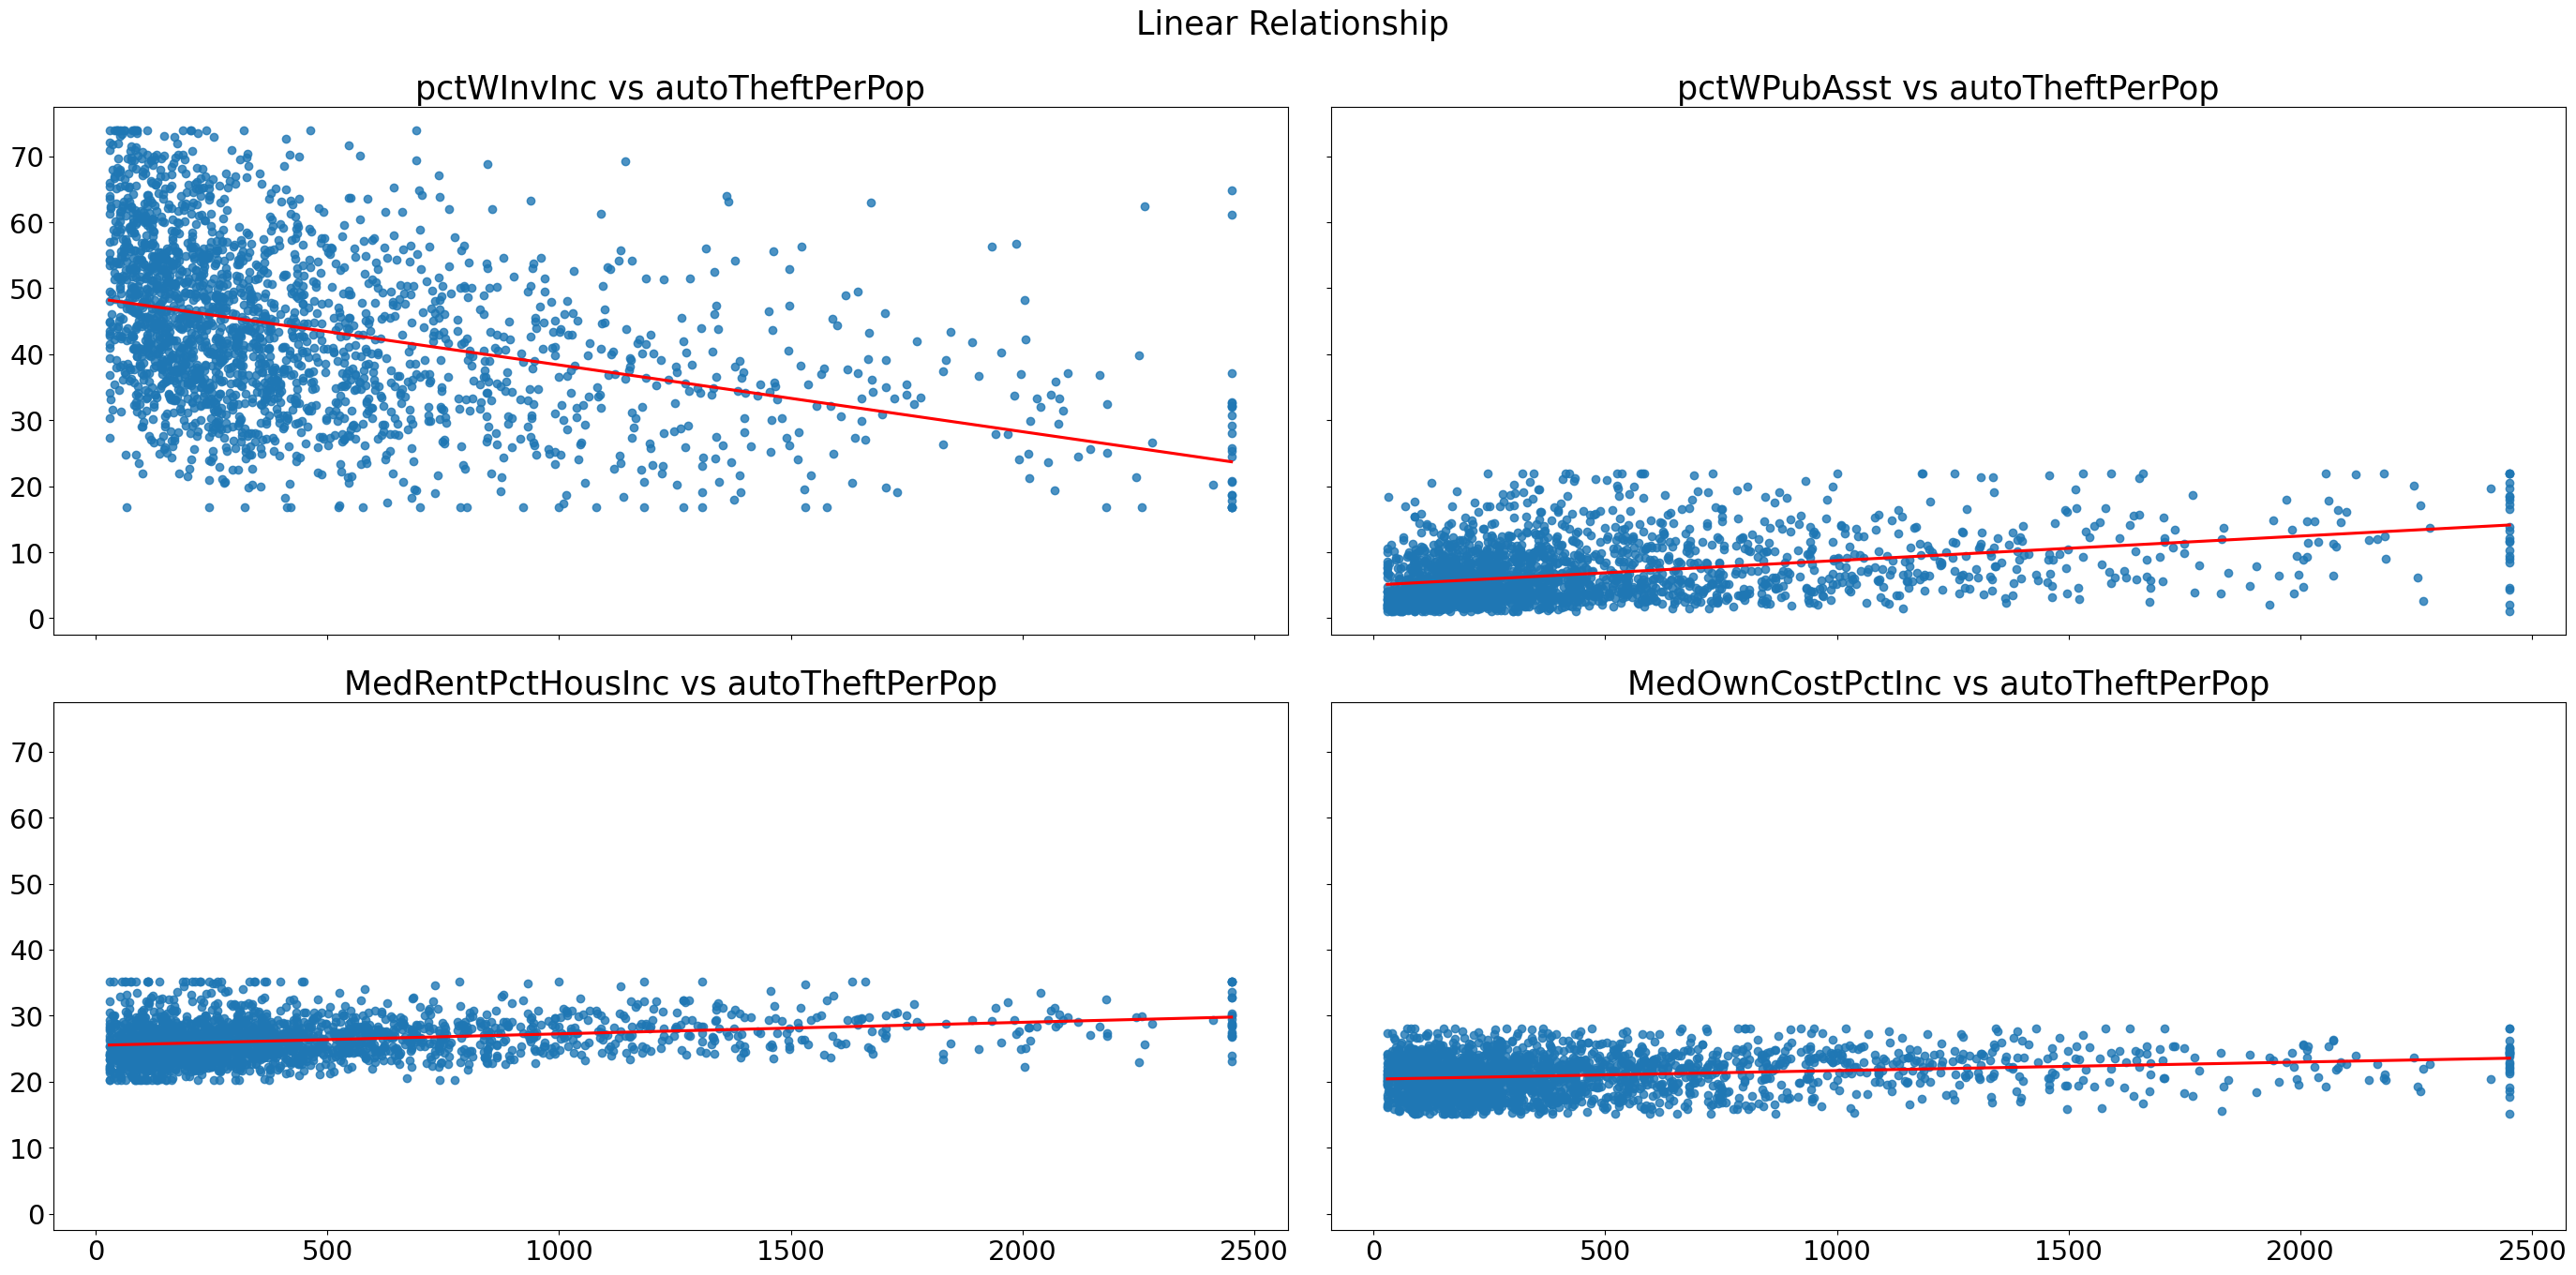

In [349]:
linear_relationship_plot(
    dataframe=crime_df,
    x="autoTheftPerPop",
    y=["pctWInvInc", "pctWPubAsst", "MedRentPctHousInc", "MedOwnCostPctInc"],
    title="Linear Relationship",
    n_rows=2,
    n_cols=2
)

## Baseline Model
---

In [350]:
# Split data into predictors and target
features = crime_df.drop(columns=['autoTheftPerPop'])
X = features
y = crime_df['autoTheftPerPop']

In [351]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [352]:
# Standardize data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [353]:
# Baseline Model: Mean of Target as Prediction
y_pred_baseline = np.full(y_test.shape, y_train.mean())
y_train_pred_baseline = np.full(y_train.shape, y_train.mean())

In [354]:
# Evaluate Baseline Model
r2_baseline_train = r2_score(y_train, y_train_pred_baseline)
r2_baseline_test = r2_score(y_test, y_pred_baseline)
mse_baseline_train = root_mean_squared_error(y_train, y_train_pred_baseline)**2
mse_baseline_test = root_mean_squared_error(y_test, y_pred_baseline)**2
rmse_baseline_train = np.sqrt(mse_baseline_train)
rmse_baseline_test = np.sqrt(mse_baseline_test)

In [355]:
print("Baseline Model Evaluation:")
print(f"  Train R2: {r2_baseline_train:.4f}")
print(f"  Test R2: {r2_baseline_test:.4f}")
print(f"  Train MSE: {mse_baseline_train:.4f}")
print(f"  Test MSE: {mse_baseline_test:.4f}")
print(f"  Train RMSE: {rmse_baseline_train:.4f}")
print(f"  Test RMSE: {rmse_baseline_test:.4f}\n")

Baseline Model Evaluation:
  Train R2: 0.0000
  Test R2: -0.0009
  Train MSE: 216850.6145
  Test MSE: 240170.1454
  Train RMSE: 465.6722
  Test RMSE: 490.0716



In [356]:
# Function to evaluate regression models
def evaluate_regression_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mse_train = root_mean_squared_error(y_train, y_train_pred)**2
    mse_test = root_mean_squared_error(y_test, y_test_pred)**2
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    
    # Print evaluation
    print(f"{model_name} Evaluation:")
    print(f"  Train R²: {r2_train:.4f}")
    print(f"  Test R²: {r2_test:.4f}")
    print(f"  Train MSE: {mse_train:.4f}")
    print(f"  Test MSE: {mse_test:.4f}")
    print(f"  Train RMSE: {rmse_train:.4f}")
    print(f"  Test RMSE: {rmse_test:.4f}\n")
    
    return {
        'Model': model_name,
        'R2_Test': r2_test,
        'MSE_Test': mse_test,
        'RMSE_Test': rmse_test,
        'y_test_pred': y_test_pred
    }

In [357]:
# Initialize list to store model evaluations
model_evaluations = []

# 1. CART Decision Tree Model
dt_model = DecisionTreeRegressor(random_state=42, max_leaf_nodes=5)
dt_results = evaluate_regression_model(dt_model, X_train_scaled, y_train, X_test_scaled, y_test, "Decision Tree")
model_evaluations.append(dt_results)

# 2. Random Forest Regressor Model
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_results = evaluate_regression_model(rf_model, X_train_scaled, y_train, X_test_scaled, y_test, "Random Forest")
model_evaluations.append(rf_results)

# 3. Gradient Boosting Regressor Model (Added for completeness)
gbm_model = GradientBoostingRegressor(random_state=42)
gbm_results = evaluate_regression_model(gbm_model, X_train_scaled, y_train, X_test_scaled, y_test, "Gradient Boosting")
model_evaluations.append(gbm_results)

# 4. XGBoost Regressor Model (Added for completeness)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_results = evaluate_regression_model(xgb_model, X_train_scaled, y_train, X_test_scaled, y_test, "XGBoost")
model_evaluations.append(xgb_results)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Model': ['Baseline', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'R²': [r2_baseline_test, dt_results['R2_Test'], rf_results['R2_Test'], gbm_results['R2_Test'], xgb_results['R2_Test']],
    'MSE': [mse_baseline_test, dt_results['MSE_Test'], rf_results['MSE_Test'], gbm_results['MSE_Test'], xgb_results['MSE_Test']],
    'RMSE': [rmse_baseline_test, dt_results['RMSE_Test'], rf_results['RMSE_Test'], gbm_results['RMSE_Test'], xgb_results['RMSE_Test']]
})

Decision Tree Evaluation:
  Train R²: 0.7079
  Test R²: 0.6418
  Train MSE: 63352.3181
  Test MSE: 85949.4434
  Train RMSE: 251.6989
  Test RMSE: 293.1714

Random Forest Evaluation:
  Train R²: 0.9865
  Test R²: 0.9064
  Train MSE: 2934.8417
  Test MSE: 22466.9602
  Train RMSE: 54.1742
  Test RMSE: 149.8898

Gradient Boosting Evaluation:
  Train R²: 0.9864
  Test R²: 0.9313
  Train MSE: 2945.8484
  Test MSE: 16484.0195
  Train RMSE: 54.2757
  Test RMSE: 128.3901

XGBoost Evaluation:
  Train R²: 1.0000
  Test R²: 0.9220
  Train MSE: 0.6005
  Test MSE: 18708.8845
  Train RMSE: 0.7749
  Test RMSE: 136.7804



In [358]:
comparison_df

,Model,R²,MSE,RMSE
0,Baseline,-0.000851,240170.145374,490.071572
1,Decision Tree,0.641826,85949.443402,293.171355
2,Random Forest,0.906374,22466.960186,149.889827
3,Gradient Boosting,0.931307,16484.019502,128.390107
4,XGBoost,0.922035,18708.884464,136.780424


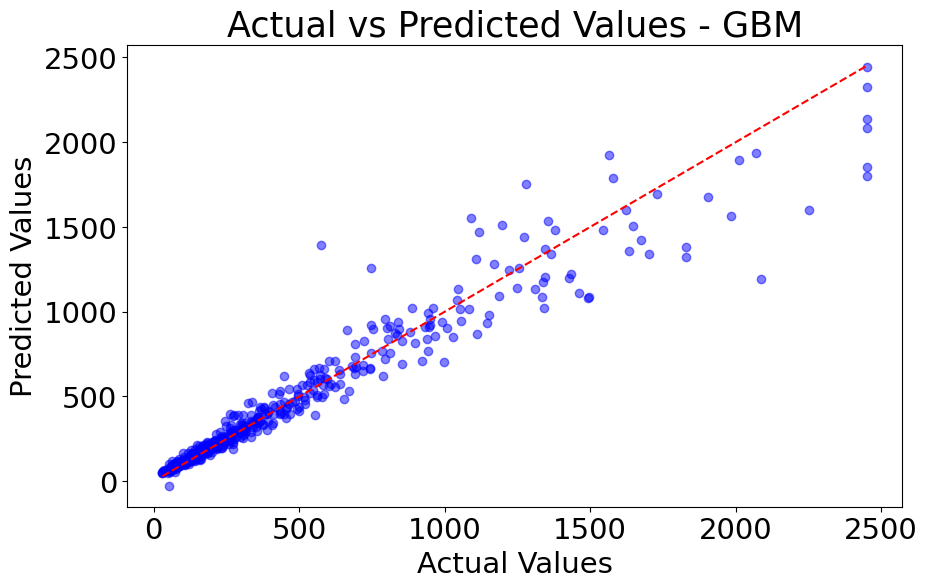

In [359]:
# Actual vs Predicted for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_test, gbm_results['y_test_pred'], alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted Values - GBM')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [360]:
# Encode target variable for classification (e.g., high vs. low auto theft rate)
# Define a threshold, e.g., median value
threshold = y.median()
y_class = np.where(y > threshold, 1, 0)

# Split data for classification
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Standardize features for classification models
X_train_clf_scaled = scaler.fit_transform(X_train_clf)
X_test_clf_scaled = scaler.transform(X_test_clf)

In [361]:
# Initialize model
linear_model = LinearRegression()

# Perform 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_r2 = cross_val_score(linear_model, X_train_scaled, y_train, cv=kf, scoring='r2')
cv_scores_mse = -cross_val_score(linear_model, X_train_scaled, y_train, cv=kf, scoring='neg_mean_squared_error')

print("Multiple Linear Regression Cross-Validation Results:")
print(f"  R² Scores: {cv_scores_r2}")
print(f"  Average R²: {cv_scores_r2.mean():.4f}")
print(f"  MSE Scores: {cv_scores_mse}")
print(f"  Average MSE: {cv_scores_mse.mean():.4f}\n")

# Fit and evaluate on test set
linear_model.fit(X_train_scaled, y_train)
y_pred_linear = linear_model.predict(X_test_scaled)
r2_linear = r2_score(y_test, y_pred_linear)
mse_linear = root_mean_squared_error(y_test, y_pred_linear)**2
rmse_linear = np.sqrt(mse_linear)

print("Multiple Linear Regression Test Set Evaluation:")
print(f"  R²: {r2_linear:.4f}")
print(f"  MSE: {mse_linear:.4f}")
print(f"  RMSE: {rmse_linear:.4f}\n")

Multiple Linear Regression Cross-Validation Results:
  R² Scores: [0.73122462 0.83437764 0.79980848 0.85093211 0.83363281]
  Average R²: 0.8100
  MSE Scores: [53344.7050969  44870.83895621 46463.59705321 25187.52668326
 35130.91057651]
  Average MSE: 40999.5157

Multiple Linear Regression Test Set Evaluation:
  R²: 0.8244
  MSE: 42147.9778
  RMSE: 205.2997



In [362]:
from sklearn.linear_model import LogisticRegression

# Initialize model
logistic_model = LogisticRegression(random_state=42, max_iter=1000)

# Perform 5-fold cross-validation
cv_scores_accuracy = cross_val_score(logistic_model, X_train_clf_scaled, y_train_clf, cv=kf, scoring='accuracy')
cv_scores_precision = cross_val_score(logistic_model, X_train_clf_scaled, y_train_clf, cv=kf, scoring='precision')
cv_scores_recall = cross_val_score(logistic_model, X_train_clf_scaled, y_train_clf, cv=kf, scoring='recall')
cv_scores_f1 = cross_val_score(logistic_model, X_train_clf_scaled, y_train_clf, cv=kf, scoring='f1')
cv_scores_roc_auc = cross_val_score(logistic_model, X_train_clf_scaled, y_train_clf, cv=kf, scoring='roc_auc')

print("Multiple Logistic Regression Cross-Validation Results:")
print(f"  Accuracy: {cv_scores_accuracy.mean():.4f}")
print(f"  Precision: {cv_scores_precision.mean():.4f}")
print(f"  Recall: {cv_scores_recall.mean():.4f}")
print(f"  F1-Score: {cv_scores_f1.mean():.4f}")
print(f"  ROC-AUC: {cv_scores_roc_auc.mean():.4f}\n")

# Fit and evaluate on test set
logistic_model.fit(X_train_clf_scaled, y_train_clf)
y_pred_logistic = logistic_model.predict(X_test_clf_scaled)
y_pred_logistic_proba = logistic_model.predict_proba(X_test_clf_scaled)[:,1]

accuracy_logistic = accuracy_score(y_test_clf, y_pred_logistic)
precision_logistic = precision_score(y_test_clf, y_pred_logistic)
recall_logistic = recall_score(y_test_clf, y_pred_logistic)
f1_logistic = f1_score(y_test_clf, y_pred_logistic)
roc_auc_logistic = roc_auc_score(y_test_clf, y_pred_logistic_proba)

print("Multiple Logistic Regression Test Set Evaluation:")
print(f"  Accuracy: {accuracy_logistic:.4f}")
print(f"  Precision: {precision_logistic:.4f}")
print(f"  Recall: {recall_logistic:.4f}")
print(f"  F1-Score: {f1_logistic:.4f}")
print(f"  ROC-AUC: {roc_auc_logistic:.4f}\n")

Multiple Logistic Regression Cross-Validation Results:
  Accuracy: 0.8668
  Precision: 0.8816
  Recall: 0.8505
  F1-Score: 0.8651
  ROC-AUC: 0.9467

Multiple Logistic Regression Test Set Evaluation:
  Accuracy: 0.8849
  Precision: 0.8932
  Recall: 0.8638
  F1-Score: 0.8783
  ROC-AUC: 0.9495



In [363]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

# Regression Task
dt_regressor = DecisionTreeRegressor(random_state=42)
cv_scores_r2_dt = cross_val_score(dt_regressor, X_train_scaled, y_train, cv=kf, scoring='r2')
cv_scores_mse_dt = -cross_val_score(dt_regressor, X_train_scaled, y_train, cv=kf, scoring='neg_mean_squared_error')

print("Decision Tree Regressor Cross-Validation Results:")
print(f"  R² Scores: {cv_scores_r2_dt}")
print(f"  Average R²: {cv_scores_r2_dt.mean():.4f}")
print(f"  MSE Scores: {cv_scores_mse_dt}")
print(f"  Average MSE: {cv_scores_mse_dt.mean():.4f}\n")

# Fit and evaluate on test set
dt_regressor.fit(X_train_scaled, y_train)
y_pred_dt = dt_regressor.predict(X_test_scaled)
r2_dt = r2_score(y_test, y_pred_dt)
mse_dt = root_mean_squared_error(y_test, y_pred_dt)**2
rmse_dt = np.sqrt(mse_dt)

print("Decision Tree Regressor Test Set Evaluation:")
print(f"  R²: {r2_dt:.4f}")
print(f"  MSE: {mse_dt:.4f}")
print(f"  RMSE: {rmse_dt:.4f}\n")

# Classification Task (Optional)
dt_classifier = DecisionTreeClassifier(random_state=42)
cv_scores_accuracy_dt = cross_val_score(dt_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='accuracy')
cv_scores_precision_dt = cross_val_score(dt_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='precision')
cv_scores_recall_dt = cross_val_score(dt_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='recall')
cv_scores_f1_dt = cross_val_score(dt_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='f1')
cv_scores_roc_auc_dt = cross_val_score(dt_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='roc_auc')

print("Decision Tree Classifier Cross-Validation Results:")
print(f"  Accuracy: {cv_scores_accuracy_dt.mean():.4f}")
print(f"  Precision: {cv_scores_precision_dt.mean():.4f}")
print(f"  Recall: {cv_scores_recall_dt.mean():.4f}")
print(f"  F1-Score: {cv_scores_f1_dt.mean():.4f}")
print(f"  ROC-AUC: {cv_scores_roc_auc_dt.mean():.4f}\n")

# Fit and evaluate on test set
dt_classifier.fit(X_train_clf_scaled, y_train_clf)
y_pred_dt_clf = dt_classifier.predict(X_test_clf_scaled)
y_pred_dt_proba_clf = dt_classifier.predict_proba(X_test_clf_scaled)[:,1]

accuracy_dt = accuracy_score(y_test_clf, y_pred_dt_clf)
precision_dt = precision_score(y_test_clf, y_pred_dt_clf)
recall_dt = recall_score(y_test_clf, y_pred_dt_clf)
f1_dt = f1_score(y_test_clf, y_pred_dt_clf)
roc_auc_dt = roc_auc_score(y_test_clf, y_pred_dt_proba_clf)

print("Decision Tree Classifier Test Set Evaluation:")
print(f"  Accuracy: {accuracy_dt:.4f}")
print(f"  Precision: {precision_dt:.4f}")
print(f"  Recall: {recall_dt:.4f}")
print(f"  F1-Score: {f1_dt:.4f}")
print(f"  ROC-AUC: {roc_auc_dt:.4f}\n")

Decision Tree Regressor Cross-Validation Results:
  R² Scores: [0.75718216 0.79565503 0.8174231  0.80858401 0.79580171]
  Average R²: 0.7949
  MSE Scores: [48192.8304686  55361.66972304 42375.31968493 32342.95139578
 43119.51137345]
  Average MSE: 44278.4565

Decision Tree Regressor Test Set Evaluation:
  R²: 0.8514
  MSE: 35670.2239
  RMSE: 188.8656

Decision Tree Classifier Cross-Validation Results:
  Accuracy: 0.8973
  Precision: 0.9094
  Recall: 0.8844
  F1-Score: 0.8966
  ROC-AUC: 0.8972

Decision Tree Classifier Test Set Evaluation:
  Accuracy: 0.9142
  Precision: 0.8924
  Recall: 0.9343
  F1-Score: 0.9128
  ROC-AUC: 0.9150



In [364]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Regression Task
rf_regressor = RandomForestRegressor(random_state=42, n_estimators=100)
cv_scores_r2_rf = cross_val_score(rf_regressor, X_train_scaled, y_train, cv=kf, scoring='r2')
cv_scores_mse_rf = -cross_val_score(rf_regressor, X_train_scaled, y_train, cv=kf, scoring='neg_mean_squared_error')

print("Random Forest Regressor Cross-Validation Results:")
print(f"  R² Scores: {cv_scores_r2_rf}")
print(f"  Average R²: {cv_scores_r2_rf.mean():.4f}")
print(f"  MSE Scores: {cv_scores_mse_rf}")
print(f"  Average MSE: {cv_scores_mse_rf.mean():.4f}\n")

# Fit and evaluate on test set
rf_regressor.fit(X_train_scaled, y_train)
y_pred_rf = rf_regressor.predict(X_test_scaled)
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = root_mean_squared_error(y_test, y_pred_rf)**2
rmse_rf = np.sqrt(mse_rf)

print("Random Forest Regressor Test Set Evaluation:")
print(f"  R²: {r2_rf:.4f}")
print(f"  MSE: {mse_rf:.4f}")
print(f"  RMSE: {rmse_rf:.4f}\n")

# Classification Task
rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100)
cv_scores_accuracy_rf = cross_val_score(rf_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='accuracy')
cv_scores_precision_rf = cross_val_score(rf_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='precision')
cv_scores_recall_rf = cross_val_score(rf_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='recall')
cv_scores_f1_rf = cross_val_score(rf_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='f1')
cv_scores_roc_auc_rf = cross_val_score(rf_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='roc_auc')

print("Random Forest Classifier Cross-Validation Results:")
print(f"  Accuracy: {cv_scores_accuracy_rf.mean():.4f}")
print(f"  Precision: {cv_scores_precision_rf.mean():.4f}")
print(f"  Recall: {cv_scores_recall_rf.mean():.4f}")
print(f"  F1-Score: {cv_scores_f1_rf.mean():.4f}")
print(f"  ROC-AUC: {cv_scores_roc_auc_rf.mean():.4f}\n")

# Fit and evaluate on test set
rf_classifier.fit(X_train_clf_scaled, y_train_clf)
y_pred_rf_clf = rf_classifier.predict(X_test_clf_scaled)
y_pred_rf_proba_clf = rf_classifier.predict_proba(X_test_clf_scaled)[:,1]

accuracy_rf = accuracy_score(y_test_clf, y_pred_rf_clf)
precision_rf = precision_score(y_test_clf, y_pred_rf_clf)
recall_rf = recall_score(y_test_clf, y_pred_rf_clf)
f1_rf = f1_score(y_test_clf, y_pred_rf_clf)
roc_auc_rf = roc_auc_score(y_test_clf, y_pred_rf_proba_clf)

print("Random Forest Classifier Test Set Evaluation:")
print(f"  Accuracy: {accuracy_rf:.4f}")
print(f"  Precision: {precision_rf:.4f}")
print(f"  Recall: {recall_rf:.4f}")
print(f"  F1-Score: {f1_rf:.4f}")
print(f"  ROC-AUC: {roc_auc_rf:.4f}\n")

Random Forest Regressor Cross-Validation Results:
  R² Scores: [0.8692627  0.88717294 0.89453695 0.89746731 0.91199381]
  Average R²: 0.8921
  MSE Scores: [25947.84862185 30567.39943006 24477.52284781 17324.62326678
 18583.81847747]
  Average MSE: 23380.2425

Random Forest Regressor Test Set Evaluation:
  R²: 0.9064
  MSE: 22466.9602
  RMSE: 149.8898

Random Forest Classifier Cross-Validation Results:
  Accuracy: 0.8888
  Precision: 0.8939
  Recall: 0.8844
  F1-Score: 0.8890
  ROC-AUC: 0.9592

Random Forest Classifier Test Set Evaluation:
  Accuracy: 0.8962
  Precision: 0.8813
  Recall: 0.9061
  F1-Score: 0.8935
  ROC-AUC: 0.9661



In [365]:
from sklearn.naive_bayes import GaussianNB

# Initialize model
nb_classifier = GaussianNB()

# Perform 5-fold cross-validation
cv_scores_accuracy_nb = cross_val_score(nb_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='accuracy')
cv_scores_precision_nb = cross_val_score(nb_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='precision')
cv_scores_recall_nb = cross_val_score(nb_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='recall')
cv_scores_f1_nb = cross_val_score(nb_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='f1')
cv_scores_roc_auc_nb = cross_val_score(nb_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='roc_auc')

print("Naive Bayes Classifier Cross-Validation Results:")
print(f"  Accuracy: {cv_scores_accuracy_nb.mean():.4f}")
print(f"  Precision: {cv_scores_precision_nb.mean():.4f}")
print(f"  Recall: {cv_scores_recall_nb.mean():.4f}")
print(f"  F1-Score: {cv_scores_f1_nb.mean():.4f}")
print(f"  ROC-AUC: {cv_scores_roc_auc_nb.mean():.4f}\n")

# Fit and evaluate on test set
nb_classifier.fit(X_train_clf_scaled, y_train_clf)
y_pred_nb_clf = nb_classifier.predict(X_test_clf_scaled)
y_pred_nb_proba_clf = nb_classifier.predict_proba(X_test_clf_scaled)[:,1]

accuracy_nb = accuracy_score(y_test_clf, y_pred_nb_clf)
precision_nb = precision_score(y_test_clf, y_pred_nb_clf)
recall_nb = recall_score(y_test_clf, y_pred_nb_clf)
f1_nb = f1_score(y_test_clf, y_pred_nb_clf)
roc_auc_nb = roc_auc_score(y_test_clf, y_pred_nb_proba_clf)

print("Naive Bayes Classifier Test Set Evaluation:")
print(f"  Accuracy: {accuracy_nb:.4f}")
print(f"  Precision: {precision_nb:.4f}")
print(f"  Recall: {recall_nb:.4f}")
print(f"  F1-Score: {f1_nb:.4f}")
print(f"  ROC-AUC: {roc_auc_nb:.4f}\n")

Naive Bayes Classifier Cross-Validation Results:
  Accuracy: 0.7534
  Precision: 0.8884
  Recall: 0.5843
  F1-Score: 0.7045
  ROC-AUC: 0.8498

Naive Bayes Classifier Test Set Evaluation:
  Accuracy: 0.7946
  Precision: 0.9122
  Recall: 0.6338
  F1-Score: 0.7479
  ROC-AUC: 0.8770



In [366]:
from xgboost import XGBRegressor, XGBClassifier

# Regression Task
xgb_regressor = XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100)
cv_scores_r2_xgb = cross_val_score(xgb_regressor, X_train_scaled, y_train, cv=kf, scoring='r2')
cv_scores_mse_xgb = -cross_val_score(xgb_regressor, X_train_scaled, y_train, cv=kf, scoring='neg_mean_squared_error')

print("XGBoost Regressor Cross-Validation Results:")
print(f"  R² Scores: {cv_scores_r2_xgb}")
print(f"  Average R²: {cv_scores_r2_xgb.mean():.4f}")
print(f"  MSE Scores: {cv_scores_mse_xgb}")
print(f"  Average MSE: {cv_scores_mse_xgb.mean():.4f}\n")

# Fit and evaluate on test set
xgb_regressor.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_regressor.predict(X_test_scaled)
r2_xgb = r2_score(y_test, y_pred_xgb)
mse_xgb = root_mean_squared_error(y_test, y_pred_xgb)**2
rmse_xgb = np.sqrt(mse_xgb)

print("XGBoost Regressor Test Set Evaluation:")
print(f"  R²: {r2_xgb:.4f}")
print(f"  MSE: {mse_xgb:.4f}")
print(f"  RMSE: {rmse_xgb:.4f}\n")

# Classification Task
xgb_classifier = XGBClassifier(objective='binary:logistic', random_state=42, n_estimators=100)
cv_scores_accuracy_xgb = cross_val_score(xgb_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='accuracy')
cv_scores_precision_xgb = cross_val_score(xgb_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='precision')
cv_scores_recall_xgb = cross_val_score(xgb_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='recall')
cv_scores_f1_xgb = cross_val_score(xgb_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='f1')
cv_scores_roc_auc_xgb = cross_val_score(xgb_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='roc_auc')

print("XGBoost Classifier Cross-Validation Results:")
print(f"  Accuracy: {cv_scores_accuracy_xgb.mean():.4f}")
print(f"  Precision: {cv_scores_precision_xgb.mean():.4f}")
print(f"  Recall: {cv_scores_recall_xgb.mean():.4f}")
print(f"  F1-Score: {cv_scores_f1_xgb.mean():.4f}")
print(f"  ROC-AUC: {cv_scores_roc_auc_xgb.mean():.4f}\n")

# Fit and evaluate on test set
xgb_classifier.fit(X_train_clf_scaled, y_train_clf)
y_pred_xgb_clf = xgb_classifier.predict(X_test_clf_scaled)
y_pred_xgb_proba_clf = xgb_classifier.predict_proba(X_test_clf_scaled)[:,1]

accuracy_xgb = accuracy_score(y_test_clf, y_pred_xgb_clf)
precision_xgb = precision_score(y_test_clf, y_pred_xgb_clf)
recall_xgb = recall_score(y_test_clf, y_pred_xgb_clf)
f1_xgb = f1_score(y_test_clf, y_pred_xgb_clf)
roc_auc_xgb = roc_auc_score(y_test_clf, y_pred_xgb_proba_clf)

print("XGBoost Classifier Test Set Evaluation:")
print(f"  Accuracy: {accuracy_xgb:.4f}")
print(f"  Precision: {precision_xgb:.4f}")
print(f"  Recall: {recall_xgb:.4f}")
print(f"  F1-Score: {f1_xgb:.4f}")
print(f"  ROC-AUC: {roc_auc_xgb:.4f}\n")

XGBoost Regressor Cross-Validation Results:
  R² Scores: [0.85628303 0.8789924  0.89466847 0.89912978 0.89711256]
  Average R²: 0.8852
  MSE Scores: [28523.96452698 32783.69330825 24446.99755564 17043.72021032
 21726.21587503]
  Average MSE: 24904.9183

XGBoost Regressor Test Set Evaluation:
  R²: 0.9220
  MSE: 18708.8845
  RMSE: 136.7804

XGBoost Classifier Cross-Validation Results:
  Accuracy: 0.9475
  Precision: 0.9464
  Recall: 0.9497
  F1-Score: 0.9480
  ROC-AUC: 0.9900

XGBoost Classifier Test Set Evaluation:
  Accuracy: 0.9661
  Precision: 0.9500
  Recall: 0.9812
  F1-Score: 0.9654
  ROC-AUC: 0.9939



In [367]:
# Compile Regression Models Performance
regression_models = pd.DataFrame({
    'Model': ['Baseline', 'Multiple Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'R²': [r2_baseline_test, r2_linear, r2_dt, r2_rf, gbm_results['R2_Test'], r2_xgb],
    'MSE': [mse_baseline_test, mse_linear, mse_dt, mse_rf, gbm_results['MSE_Test'], mse_xgb],
    'RMSE': [rmse_baseline_test, rmse_linear, rmse_dt, rmse_rf, gbm_results['RMSE_Test'], rmse_xgb]
})

print("Regression Models Comparison:")
print(regression_models)

# Compile Classification Models Performance
classification_models = pd.DataFrame({
    'Model': ['Multiple Logistic Regression', 'Decision Tree Classifier', 'Random Forest Classifier', 'Naive Bayes', 'XGBoost Classifier'],
    'Accuracy': [accuracy_logistic, accuracy_dt, accuracy_rf, accuracy_nb, accuracy_xgb],
    'Precision': [precision_logistic, precision_dt, precision_rf, precision_nb, precision_xgb],
    'Recall': [recall_logistic, recall_dt, recall_rf, recall_nb, recall_xgb],
    'F1-Score': [f1_logistic, f1_dt, f1_rf, f1_nb, f1_xgb],
    'ROC-AUC': [roc_auc_logistic, roc_auc_dt, roc_auc_rf, roc_auc_nb, roc_auc_xgb]
})

print("\nClassification Models Comparison:")
print(classification_models)

Regression Models Comparison:
                        Model        R²            MSE        RMSE
0                    Baseline -0.000851  240170.145374  490.071572
1  Multiple Linear Regression  0.824358   42147.977774  205.299727
2               Decision Tree  0.851353   35670.223853  188.865624
3               Random Forest  0.906374   22466.960186  149.889827
4           Gradient Boosting  0.931307   16484.019502  128.390107
5                     XGBoost  0.922035   18708.884464  136.780424

Classification Models Comparison:
                          Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0  Multiple Logistic Regression  0.884876   0.893204  0.863850  0.878282  0.949541
1      Decision Tree Classifier  0.914221   0.892377  0.934272  0.912844  0.914962
2      Random Forest Classifier  0.896163   0.881279  0.906103  0.893519  0.966054
3                   Naive Bayes  0.794582   0.912162  0.633803  0.747922  0.876975
4            XGBoost Classifier  0.966140   0.95000

In [368]:
regression_models.to_csv("../data/regression_models.csv", index=False)
classification_models.to_csv("../data/classification_models.csv", index=False)

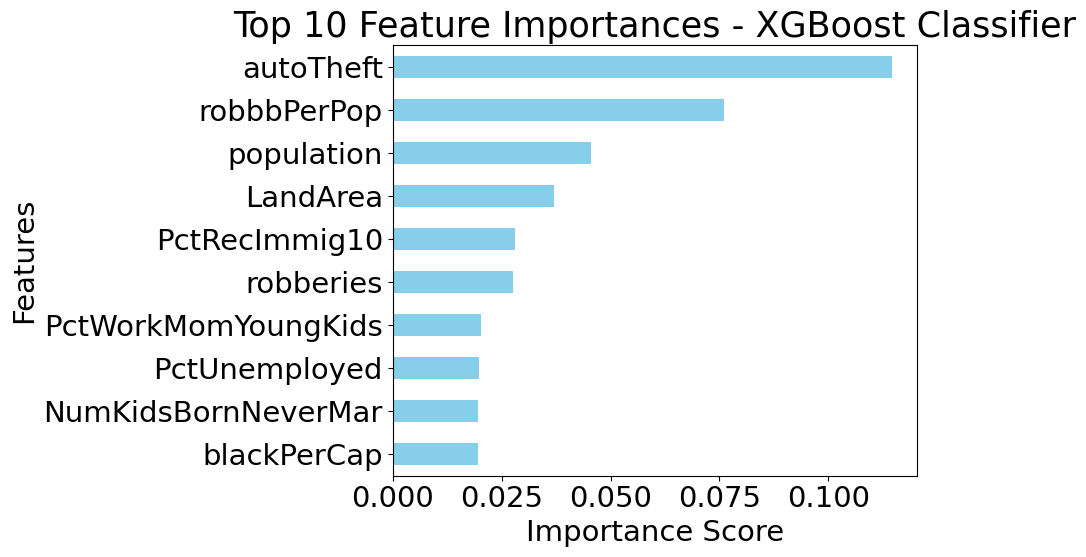

In [369]:
# Feature Importance (Using Random Forest)
feature_importances = pd.Series(xgb_classifier.feature_importances_, index=features.columns)
top_features = feature_importances.nlargest(10)
plt.figure(figsize=(10, 6))
top_features.sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 10 Feature Importances - XGBoost Classifier')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


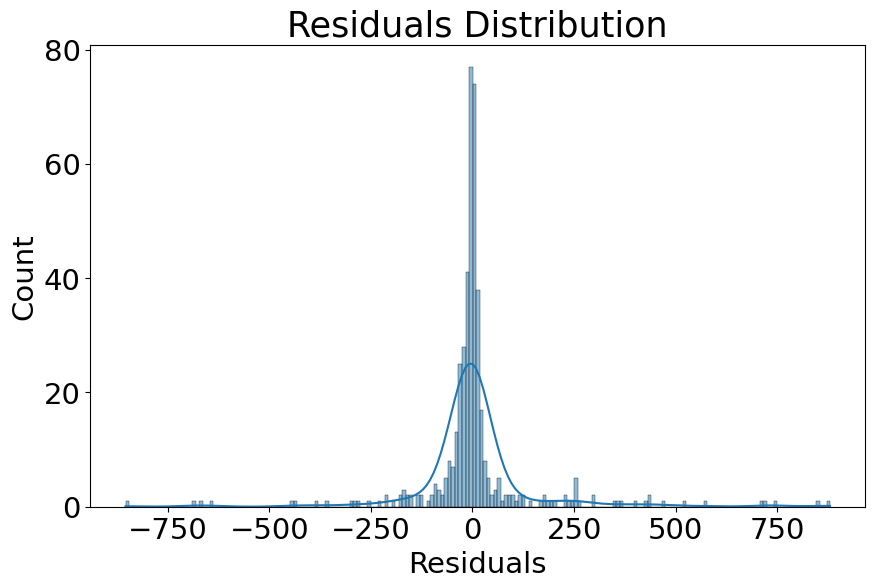

In [370]:
# Residual Analysis
residuals = y_test - y_pred_rf
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.show()

In [371]:
# Comparison Table for aActual vs Predicted Values
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rf})
comparison_df.head()

,Actual,Predicted
1466,1083.85,1096.1742
1418,271.74,395.8235
581,130.95,127.5717
1517,841.00,940.3301
1231,301.00,270.1417
